# 2b - Find year where region reaches steady-state

- Computes year where region reaches steady-state
- creates **supplementary figure S8**

---
Some more technical discussion points on that:
- the idea was to compute a year where the steady-state is reached, the problem is that the different models vary strongly in their interannual/decadal variability, even after doing a rolling average over 21 or 101 years. That means, it is not so straightforward to calculate that year and the year where steady state is reached also somehow depends on the definition. For most analysis, we therefore prefer the response time scale (i.e. year where 80% of the changes occur)....
- For some models, it is very "easy" to compute that year, for others, the thresholds would need to be set manually ...
    - e.g. in GloGEMFlow, when steady-state is reached, the volume varies internally in a 50-year cycle (probably that has been set like that...). That means the internal variability gets only "removed" if doing an above 50-yr rolling average !
    - other models have also interannual variability, but that is less regular and can be still visible on 20-year rolling averages and sometimes even on 100-yr rolling averages ...

In [1]:
# and change the path to your local path
DATE = 'Feb12_2024' 
fill_option = 'repeat_last_101yrs' 

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
# for plots withinplots 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from help_functions import pal_models, model_order, d_reg_num_name, model_order_anonymous, compute_steady_state_yr, cmap, scaler


try:
    path_merged_runs_scaled = f'../data/GMIP3_reg_glacier_model_data/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_{fill_option}.nc'
    path_merged_runs_scaled_extend = f'../data/GMIP3_reg_glacier_model_data/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled_extend)
    ds_reg_models_extend = xr.open_dataset(path_merged_runs_scaled_extend)
except:
    path_merged_runs_scaled = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
    path_merged_runs_scaled_extend = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    # we don' want to have the extended dataset to get the equilibrium values ... 
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled)
    ds_reg_models_extend = xr.open_dataset(path_merged_runs_scaled_extend)




In [3]:
hue_order_anonymous = []

pal_models_l = []
hue_order = []
for m, p in zip(model_order, pal_models):
    if (m!='OGGM-VAS') and (m!='OGGM_v153'):
        hue_order.append(m)
        pal_models_l.append(p)
for m in hue_order:
    hue_order_anonymous.append(model_order_anonymous[m])
pal_models = pal_models_l

print(hue_order, hue_order_anonymous)
# select the right models:
ds_reg_models = ds_reg_models.sel(model_author = hue_order)
pal_models = sns.color_palette(pal_models)

dict_model_col = {}
for c,m in zip(pal_models, hue_order):
    dict_model_col[m] = c
    
# select the right models
glac_models = hue_order
   
ds_reg_models = ds_reg_models.sel(model_author=glac_models)
ds_reg_models_extend = ds_reg_models_extend.sel(model_author=glac_models)
ds_reg_models_vol = ds_reg_models.volume_m3 #.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']
ds_reg_models_extend_vol = ds_reg_models_extend.volume_m3
# Let's take the median estimate from all glacier models for every RGI region and then do the sum:
ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])
ds_reg_models_extend_vol = ds_reg_models_extend_vol.stack(experiments=['gcm','period_scenario'])

ds_reg_models_med_vol = ds_reg_models_vol.median(dim='model_author')
num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)', 6:'(g)', 7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 


['PyGEM-OGGM_v13', 'GloGEMflow', 'GloGEMflow3D', 'OGGM_v16', 'GLIMB', 'Kraaijenbrink', 'GO', 'CISM2'] ['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6', 'model 7', 'model 8']


In [4]:
# true for all
init_vol = ds_reg_models_vol.isel(simulation_year=0)
ds_reg_models_vol_roll = 100*ds_reg_models_vol.rolling(simulation_year=20, center=True).mean()/init_vol
ds_reg_models_vol_extend_roll = 100*ds_reg_models_extend_vol.rolling(simulation_year=20, center=True).mean()/init_vol

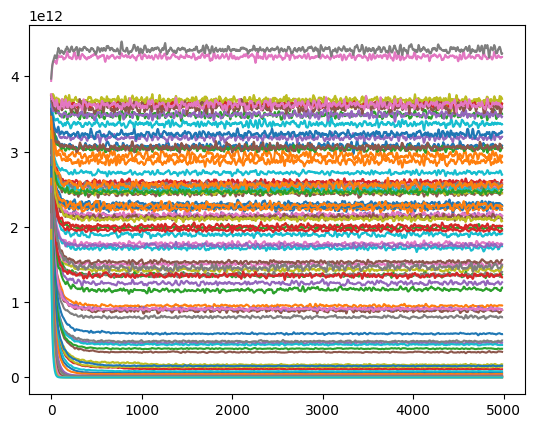

In [5]:
ds_sel = ds_reg_models_vol.rolling(simulation_year=20,center=True).mean().sel(model_author='GO').sel(rgi_reg='06').dropna(dim='simulation_year');
plt.plot(ds_sel);

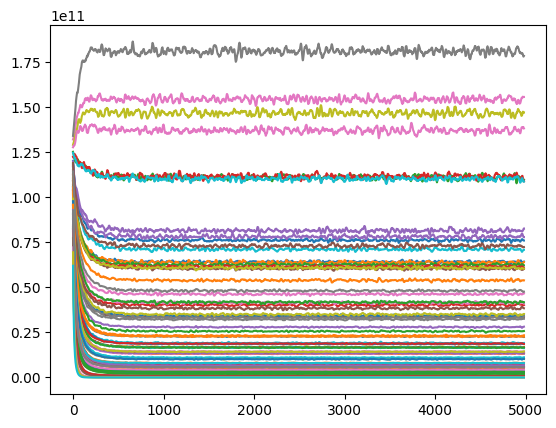

In [6]:
ds_sel = ds_reg_models_vol.rolling(simulation_year=20,center=True).mean().sel(model_author='GLIMB').sel(rgi_reg='11').dropna(dim='simulation_year');
plt.plot(ds_sel);

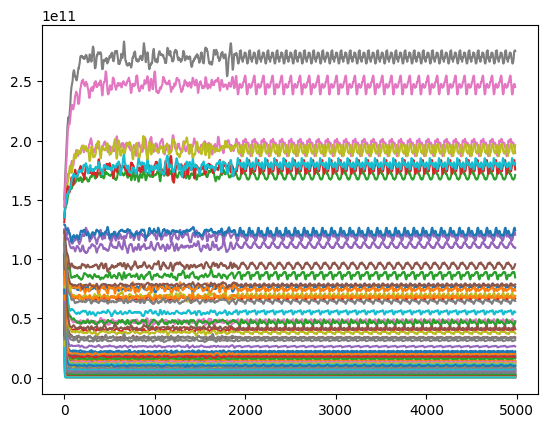

In [7]:
ds_sel = ds_reg_models_vol.rolling(simulation_year=20,center=True).mean().sel(model_author='OGGM_v16').sel(rgi_reg='11').dropna(dim='simulation_year');
plt.plot(ds_sel);

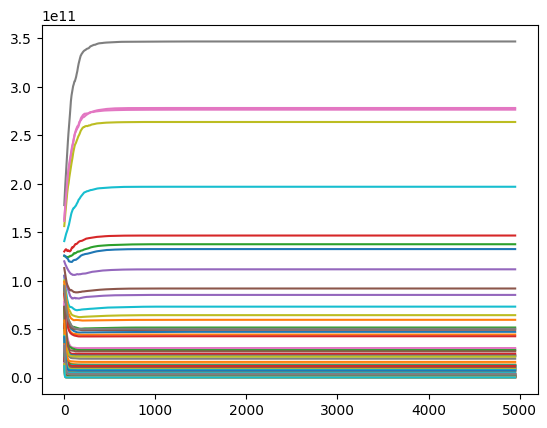

In [8]:
ds_sel = ds_reg_models_vol.rolling(simulation_year=50,center=True).mean().sel(model_author='PyGEM-OGGM_v13').sel(rgi_reg='11').dropna(dim='simulation_year');
plt.plot(ds_sel);

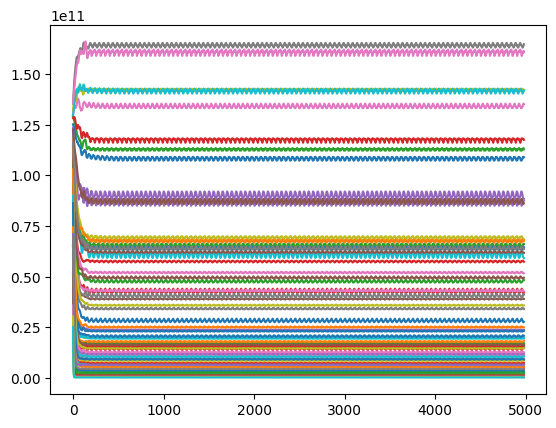

In [9]:
ds_sel = ds_reg_models_vol.rolling(simulation_year=20,center=True).mean().sel(model_author='GloGEMflow').sel(rgi_reg='11').dropna(dim='simulation_year');
plt.plot(ds_sel);

(4000.0, 4400.0)

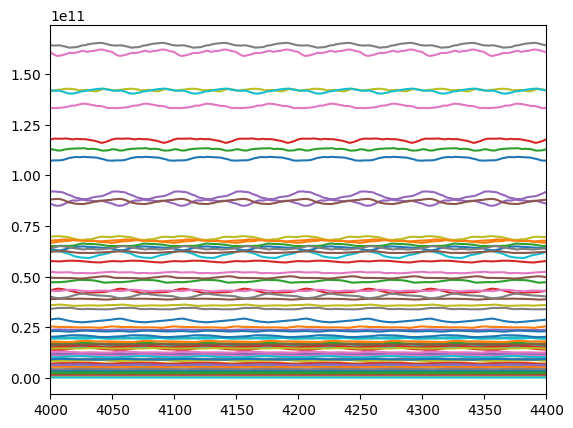

In [10]:
plt.plot(ds_sel);
plt.xlim([4000,4400])
# around 8 cycles in 400 years for GloGEMflow

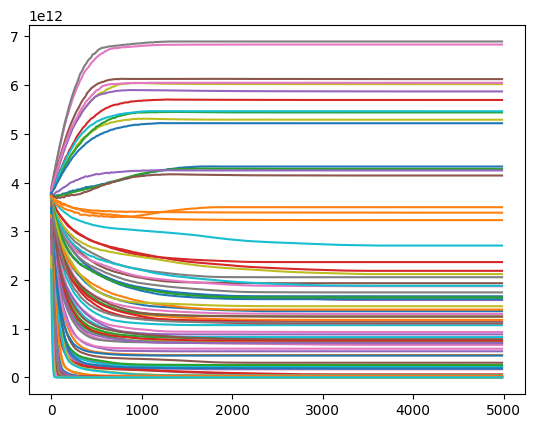

In [11]:
ds_sel = ds_reg_models_vol.rolling(simulation_year=20,center=True).mean().sel(model_author='GloGEMflow3D').sel(rgi_reg='06').dropna(dim='simulation_year');
plt.plot(ds_sel);

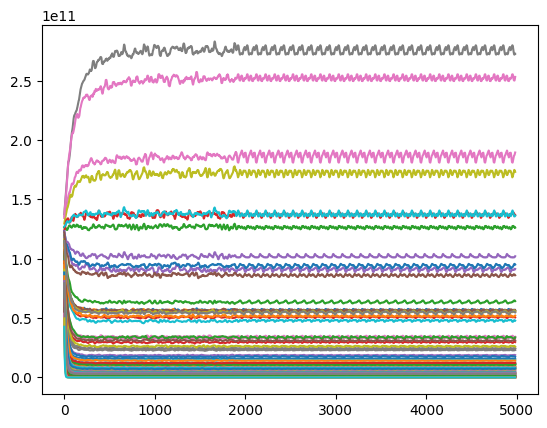

In [12]:
ds_sel = ds_reg_models_vol.rolling(simulation_year=20,center=True).mean().sel(model_author='CISM2').sel(rgi_reg='11').dropna(dim='simulation_year');
plt.plot(ds_sel);

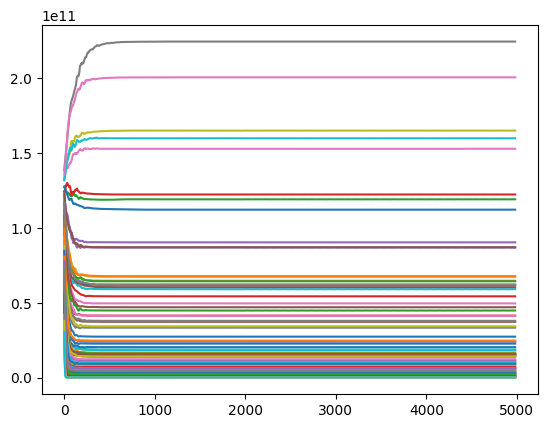

In [13]:
ds_sel = ds_reg_models_vol.rolling(simulation_year=20,center=True).mean().sel(model_author='GloGEMflow3D').sel(rgi_reg='11').dropna(dim='simulation_year');
plt.plot(ds_sel);

# Figure for supplements --- 
- xperc = 1, min_period 20 

**try with differext avg_yrs**:
- the problem is then that there are regions/experiments where the equilibrium was actually reached earlier, but this is not visible depending on which avg_yrs rolling average is chose ... 

$|\frac{Vr(yr)-Vr(yr-20)}{V(yr=0)-Vr(steady-state)}|$

In [14]:
# just to get the correct 1.5 and 3.0°C colors .... 
  
colors_15_30 = cmap(scaler.transform(np.array([1.5,3.0]).reshape(-1,1)))
colors_15_30 = sns.color_palette(colors_15_30)

In [15]:
ds_reg_models_vol = ds_reg_models.volume_m3 #.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']
ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])
init_vol = ds_reg_models_vol.isel(simulation_year=0)
min_periods=20
# make a rolling average over avg_year years, but allow min_periods(here 20 years) to compute the estimates 


In [16]:

pd_avg_exps= pd.read_csv('../data/climate_input_data/temp_ch_ipcc_ar6_isimip3b.csv', index_col=[0])
glob_temp_ch = pd_avg_exps.set_index(['gcm', 'period_scenario'])

# let's do a loop, maybe there is an easier way, but it does not matter too much 
pd_l = []
for option in ['relative_to_total_change','relative_to_initial_state']:
    for avg_yrs in [101]: #61,  # 21, 
        for threshold_total_change in [0]: #15,
            # could set to 25 similar as for the response time analysis 
            ds_reg_models_vol_roll_avg_yrs = 100*ds_reg_models_vol.rolling(simulation_year=avg_yrs, center=True).mean()/init_vol
            #ds_reg_models_vol_extend_roll_avg_yrs = 100*ds_reg_models_extend_vol.rolling(simulation_year=avg_yrs, center=True).mean()/init_vol
            for xperc in [0.5,2]: # 1
                for rgi_reg in ds_reg_models_vol.rgi_reg.values:
                    for model in ds_reg_models_vol.model_author.values:
                        ds_sel = ds_reg_models_vol_roll_avg_yrs.sel(model_author=model).sel(rgi_reg=rgi_reg).dropna(dim='simulation_year')
                        equilibrium_yr_lower_xperc_ch = compute_steady_state_yr(ds_sel,  option=option,
                                                                                threshold_total_change=threshold_total_change, xperc=xperc,
                                                                               minimum_period=min_periods)
                        # create pandas dataframe that can be concatenated ... 
                        year_reached_name = f'sim_yr_where_ss_lower_{xperc}perc_ch_reached_{option}_{avg_yrs}yr_vol_avg_{threshold_total_change}%_total_ch_threshold_min_period_{min_periods}'
                        pd_equilibrium_yr_lower_xperc_ch_avg_yrs = pd.DataFrame(equilibrium_yr_lower_xperc_ch).rename(columns={'simulation_year':year_reached_name})

                        # add temp. series ... 
                        pd_equilibrium_yr_lower_xperc_ch_avg_yrs['temp_ch_ipcc']= glob_temp_ch.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.index]['temp_ch_ipcc'].values

                        pd_equilibrium_yr_lower_xperc_ch_avg_yrs['rgi_reg'] = rgi_reg
                        pd_equilibrium_yr_lower_xperc_ch_avg_yrs['model'] = model
                        pd_equilibrium_yr_lower_xperc_ch_avg_yrs['option'] = option
                        # for those experiments, we need to check the extended time series ... 
                        #pd_equilibrium_yr_lower_1perc_ch.loc[pd_equilibrium_yr_lower_1perc_ch['simulation_yr_where_equilibrium_lower_1perc_ch_reached'].isna()]
                        pd_l.append(pd_equilibrium_yr_lower_xperc_ch_avg_yrs)
pd_equilibrium_yr_lower_xperc_ch_avg_yrs = pd.concat(pd_l)

pd_equilibrium_yr_lower_xperc_ch_avg_yrs = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.reset_index()
pd_equilibrium_yr_lower_xperc_ch_avg_yrs.index = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc
#pd_equilibrium_yr_lower_xperc_ch_avg_yrs = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.dropna()
pd_equilibrium_yr_lower_xperc_ch_avg_yrs_all = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.copy()
#pd_equilibrium_yr_lower_xperc_ch_avg_yrs_f = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc>=0.8]
#pd_equilibrium_yr_lower_xperc_ch_avg_yrs_f.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs_f.simulation_yr_where_equilibrium_lower_1perc_ch_reached ==100001]#.groupby('rgi_reg').count()

/tmp/ipykernel_1870363/958156033.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd_equilibrium_yr_lower_xperc_ch_avg_yrs = pd.concat(pd_l)


In [17]:
# extracts some numberrs
xperc = 0.5
avg_yrs = 101
option = 'relative_to_total_change'
threshold_total_change = 0


year_reached_name = f'sim_yr_where_ss_lower_{xperc}perc_ch_reached_{option}_{avg_yrs}yr_vol_avg_{threshold_total_change}%_total_ch_threshold_min_period_{min_periods}'
pd_equilibrium_yr_lower_xperc_ch_avg_yrs = pd_equilibrium_yr_lower_xperc_ch_avg_yrs_all[['gcm','period_scenario', 'rgi_reg','model',
                                                                                         'temp_ch_ipcc',year_reached_name]].dropna()

plt.rc('font', size=24)  

rgi_regs = ['01', '02', '03', '04', '05', '06', '07',
                   '08', '09', '10', '11', '12', '13', '14', '15',
                   '16', '17', '18', '19'] #'All',

condi15 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[(pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc>1.3) & (pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc<1.7)].index # 1.75 ... 
condi30 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[(pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc>2.8) & (pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc<3.2)].index
n15 = len(condi15.unique())
n30 = len(condi30.unique())
pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[condi15,'temp_ch_class'] = f'1.5±0.2°C (n={n15})'
pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[condi30,'temp_ch_class'] = f'3.0±0.2°C (n={n30})'


In [18]:
# 97 % of all experiments reach steady state 
ss_reached_all_amount = len(pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs['sim_yr_where_ss_lower_0.5perc_ch_reached_relative_to_total_change_101yr_vol_avg_0%_total_ch_threshold_min_period_20']<5000])
all_exps_amount = len(pd_equilibrium_yr_lower_xperc_ch_avg_yrs)
ss_reached_all_amount/all_exps_amount

0.9688858695652174

In [19]:
pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs['sim_yr_where_ss_lower_0.5perc_ch_reached_relative_to_total_change_101yr_vol_avg_0%_total_ch_threshold_min_period_20']<5000]['sim_yr_where_ss_lower_0.5perc_ch_reached_relative_to_total_change_101yr_vol_avg_0%_total_ch_threshold_min_period_20'].quantile([0.05,0.25,0.5,0.75,0.95])

0.05      95.0
0.25     164.0
0.50     316.0
0.75     732.5
0.95    4454.0
Name: sim_yr_where_ss_lower_0.5perc_ch_reached_relative_to_total_change_101yr_vol_avg_0%_total_ch_threshold_min_period_20, dtype: float64

In [20]:
pd_eq_ab_12 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc>=1.2].copy()
# just a check if the 100000 vaoues for not reaching steady-state influences the quantlies --> no, it does NOT 
pd_eq_ab_12.loc[pd_eq_ab_12['sim_yr_where_ss_lower_0.5perc_ch_reached_relative_to_total_change_101yr_vol_avg_0%_total_ch_threshold_min_period_20'] == 100001.0, 'sim_yr_where_ss_lower_0.5perc_ch_reached_relative_to_total_change_101yr_vol_avg_0%_total_ch_threshold_min_period_20'] = 1000000000
pd_eq_ab_12['sim_yr_where_ss_lower_0.5perc_ch_reached_relative_to_total_change_101yr_vol_avg_0%_total_ch_threshold_min_period_20'].quantile([0.05,0.25,0.5,0.75,0.95])

0.05      91.00
0.25     142.75
0.50     247.50
0.75     495.00
0.95    2232.10
Name: sim_yr_where_ss_lower_0.5perc_ch_reached_relative_to_total_change_101yr_vol_avg_0%_total_ch_threshold_min_period_20, dtype: float64

In [21]:
pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_class.unique()

array(['nan', '1.5±0.2°C (n=14)', '3.0±0.2°C (n=7)'], dtype=object)

In [22]:
pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_class == '1.5±0.2°C 065231920652319206523192(n=14)']['sim_yr_where_ss_lower_0.5perc_ch_reached_relative_to_total_change_101yr_vol_avg_0%_total_ch_threshold_min_period_20'].quantile([0.05,0.25,0.5,0.75,0.95])

0.05   NaN
0.25   NaN
0.50   NaN
0.75   NaN
0.95   NaN
Name: sim_yr_where_ss_lower_0.5perc_ch_reached_relative_to_total_change_101yr_vol_avg_0%_total_ch_threshold_min_period_20, dtype: float64

In [23]:
pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_class == '3.0±0.2°C (n=7)']['sim_yr_where_ss_lower_0.5perc_ch_reached_relative_to_total_change_101yr_vol_avg_0%_total_ch_threshold_min_period_20'].quantile([0.05,0.25,0.5,0.75,0.95])

0.05      96.00
0.25     127.00
0.50     210.50
0.75     383.00
0.95    1076.25
Name: sim_yr_where_ss_lower_0.5perc_ch_reached_relative_to_total_change_101yr_vol_avg_0%_total_ch_threshold_min_period_20, dtype: float64

In [24]:
pd_equilibrium_yr_lower_xperc_ch_avg_yrs['sim_yr_where_ss_lower_0.5perc_ch_reached_relative_to_total_change_101yr_vol_avg_0%_total_ch_threshold_min_period_20'].min()

72.0

In [25]:
pd_equilibrium_yr_lower_xperc_ch_avg_yrs['sim_yr_where_ss_lower_0.5perc_ch_reached_relative_to_total_change_101yr_vol_avg_0%_total_ch_threshold_min_period_20'].quantile(0.9)

1966.0

**only the chosen approach and rotated plot**

In [26]:
pd_rgi_stats_w_hugonnet = pd.read_csv('../data/3_shift_summary_region_characteristicsFeb12_2024.csv', index_col=[0])

pd_rgi_stats_w_hugonnet.loc[pd_rgi_stats_w_hugonnet.index,'%_2020_rel_global'] = (100*pd_rgi_stats_w_hugonnet['regional_volume_m3_2020_via_5yravg']/pd_rgi_stats_w_hugonnet.loc['All']['regional_volume_m3_2020_via_5yravg']).values
pd_hugo_far_reg = pd_rgi_stats_w_hugonnet.drop('All')
rgi_regs_sel_sorted_vol = pd_hugo_far_reg.sort_values(by='%_2020_rel_global', ascending=False).index.values
d_reg_num_name['19'] = 'Sub- & Antarctic Islands'

0.5 101 relative_to_total_change 0
year (yr) with steady-state condition:  $|\frac{Vr(yr)-Vr(yr-20)}{Vr(yr=0)-Vr(steady-state)}|$<0.5% (Vr=101-year rolling volume avg.)


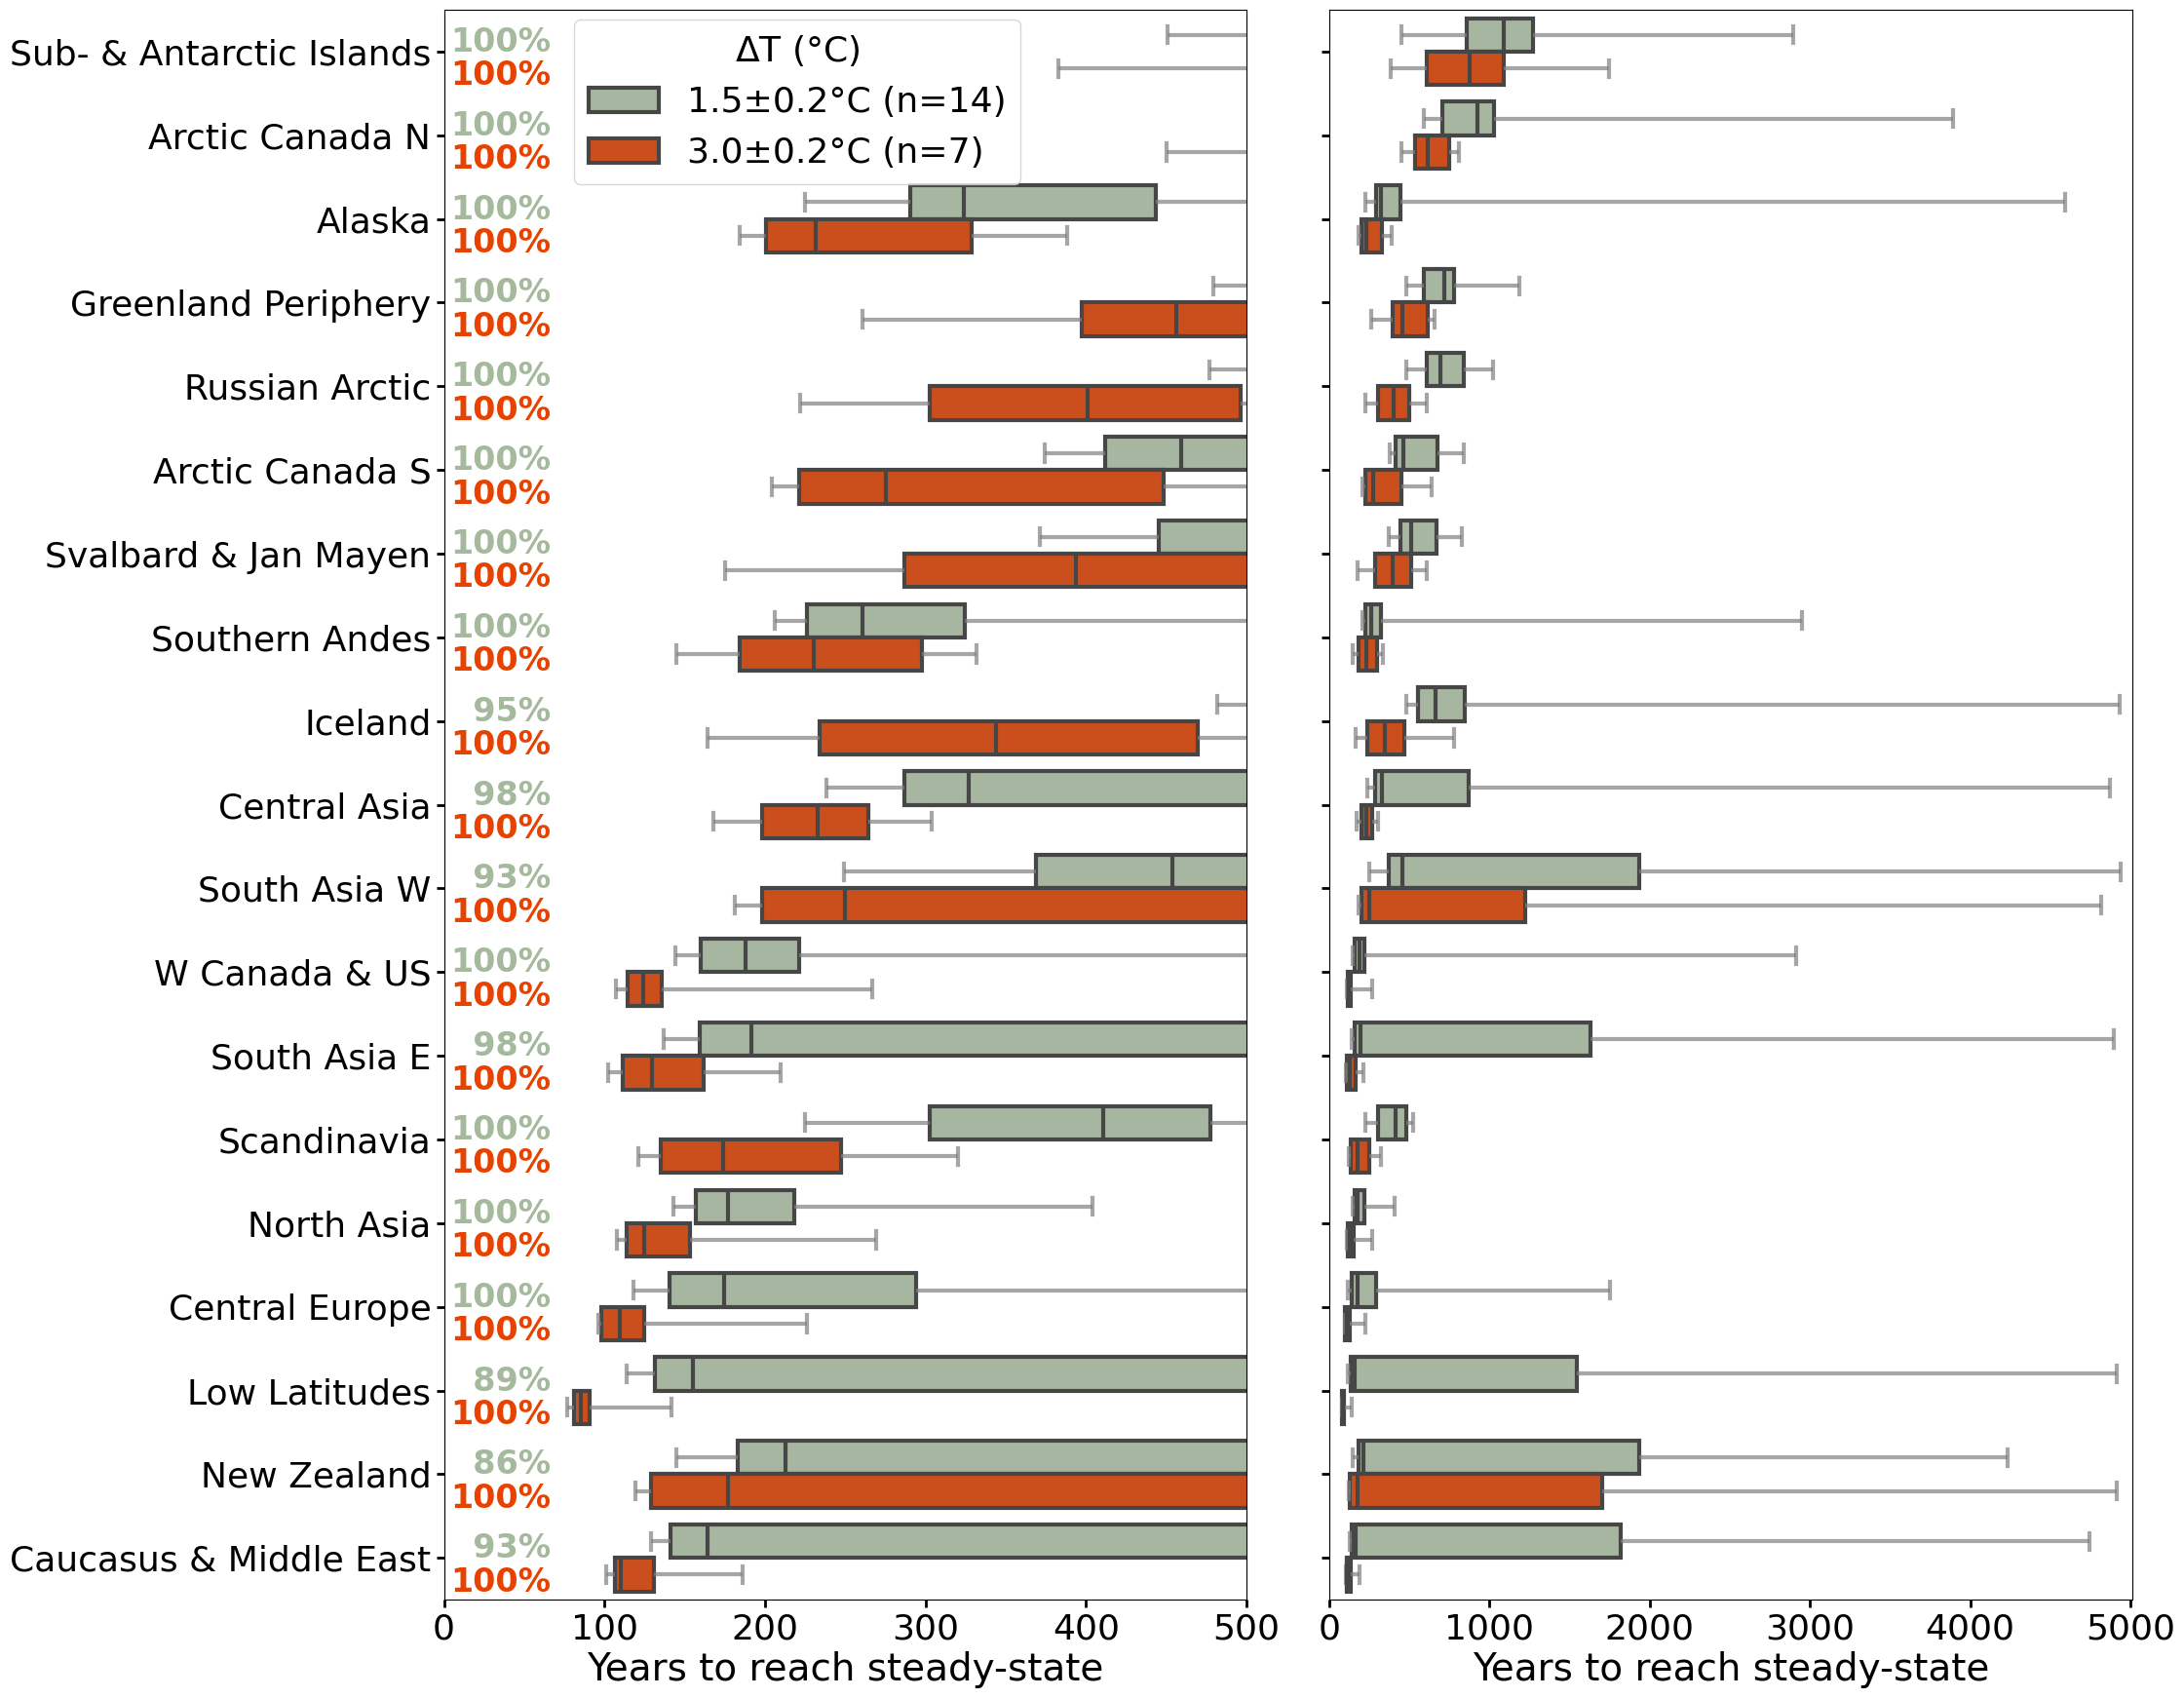

In [31]:
for xperc in [0.5]: #,1,2]:
    for avg_yrs in [101]: ###  21, 
        for option in ['relative_to_total_change']: #,'relative_to_initial_state']:
            for threshold_total_change in [0]: #,25]:
                print(xperc, avg_yrs, option, threshold_total_change)
                year_reached_name = f'sim_yr_where_ss_lower_{xperc}perc_ch_reached_{option}_{avg_yrs}yr_vol_avg_{threshold_total_change}%_total_ch_threshold_min_period_{min_periods}'
                pd_equilibrium_yr_lower_xperc_ch_avg_yrs = pd_equilibrium_yr_lower_xperc_ch_avg_yrs_all[['gcm','period_scenario', 'rgi_reg','model',
                                                                                                         'temp_ch_ipcc',year_reached_name]].dropna()

                plt.rc('font', size=26)  

                rgi_regs = rgi_regs_sel_sorted_vol
                _r_ind = pd_hugo_far_reg.index
                reg_label_l = []
                for _r in rgi_regs:
                    reg_label_l.append(f'{d_reg_num_name[_r]}') # ({_r})')
                    pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.rgi_reg==_r, '%_2020_rel_global'] = pd_hugo_far_reg.loc[_r,'%_2020_rel_global']
                    pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.rgi_reg==_r, 'rgi_reg_used'] = f'{d_reg_num_name[_r]}'# 
                #.loc[_r_ind,'%_2020_rel_global'] = pd_hugo_far_reg['%_2020_rel_global']
                pd_equilibrium_yr_lower_xperc_ch_avg_yrs = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.sort_values(by='%_2020_rel_global', ascending = False)
                
                condi15 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[(pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc>1.3) 
                                                                       & (pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc<1.7)].index
                condi30 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[(pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc>2.8)
                                                                       & (pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc<3.2)].index
                n15 = len(condi15.unique())
                n30 = len(condi30.unique())
                pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[condi15,'temp_ch_class'] = f'1.5±0.2°C (n={n15})'
                pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[condi30,'temp_ch_class'] = f'3.0±0.2°C (n={n30})'


                fig, axs=plt.subplots(1,2,figsize=(23,18),  sharey=True)
                for jj,ax in enumerate(axs):
                    #pd_equilibrium_yr_lower_xperc_ch_avg_yrs_f = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc>=0.8]
                    # only those where equilibrium is reached ...
                    sns.boxplot(data=pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs[year_reached_name]<=5000],
                                y='rgi_reg_used',x=year_reached_name,
                               dodge = True, fliersize=0, whis = [5,95],
                                hue='temp_ch_class', hue_order = [f'1.5±0.2°C (n={n15})',f'3.0±0.2°C (n={n30})'],
                                                        linewidth=3,
                                            palette = colors_15_30,
                                                        capprops={'color':'grey', 'alpha':0.7},
                                                        whiskerprops={'color':'grey', 'alpha':0.7}, ax=ax)
                    ax.set_xlabel('Years to reach steady-state', fontsize=28)

                    if jj==1:
                        ax.set_xlim([0,5010])
                        ax.legend().remove()
                        ax.set_ylabel('')
                    else:
                        ax.set_xlim([0,500])
                        ax.set_ylabel('')
                        #ax.set_yticks(rgi_regs, reg_label_l)
                        ax.legend(loc='upper center', title=r'$\Delta$T (°C)', bbox_to_anchor=(0.44,1.005))
                        texti_now = False
                        #if texti_now: 
                        for j,rgi_reg in enumerate(rgi_regs):
                            condi3 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.rgi_reg==rgi_reg
                            _selcondi3 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[condi3]

                            condi1_15 = _selcondi3.temp_ch_class==f'1.5±0.2°C (n={n15})'
                            condi1_30 = _selcondi3.temp_ch_class==f'3.0±0.2°C (n={n30})'

                            condi2 = _selcondi3[year_reached_name]<5000

                            _sel = _selcondi3.loc[(condi1_30)&(condi2)]
                            perc_30 = 100*len(_sel)/(len(_selcondi3.model.unique()) * n30)
                            #print(rgi_reg, perc_30)
                            perc_30 = np.round(perc_30)

                            _sel = _selcondi3.loc[(condi1_15)&(condi2)]
                            perc_15 = 100*len(_sel)/(len(_selcondi3.model.unique()) * n15)
                            #print(rgi_reg,perc_15)
                            perc_15 = np.round(perc_15)
                            if perc_15<100:
                                ax.text(4,-0.0+j,f'  {perc_15:.0f}%', color=colors_15_30[0], fontsize=24, weight = 'bold')
                            else:
                                ax.text(4,-0.0+j,f'{perc_15:.0f}%', color=colors_15_30[0], fontsize=24, weight = 'bold')
                            ax.text(4,0.4+j,f'{perc_30:.0f}%', color=colors_15_30[1], fontsize=24, weight='bold')
                    ax.tick_params(axis='both', which='major', width=2, length=6)
                if texti_now: 
                    plt.text(-0.4,28, f'relative amount of glacier models & experiments reaching steady-state (in %):', color='grey', fontsize=20)
                if option == 'relative_to_total_change':
                    if avg_yrs==21:
                        print('year (yr) with steady-state condition: '+r' $|\frac{Vr(yr)-Vr(yr-20)}{Vr(yr=0)-Vr(steady-state)}|$<'+f'{xperc}%'+ f'\n(Vr={avg_yrs}-year rolling volume average, threshold total change: {threshold_total_change})',
                                    )
                    elif avg_yrs==61:
                        print('year (yr) with steady-state condition: '+r' $|\frac{Vr(yr)-Vr(yr-20)}{Vr(yr=0)-Vr(steady-state)}|$<'+f'{xperc}%'+ f'\n(Vr={avg_yrs}-year rolling volume average, threshold total change: {threshold_total_change})',
                                    )

                    elif avg_yrs==101:
                        print('year (yr) with steady-state condition: '+r' $|\frac{Vr(yr)-Vr(yr-20)}{Vr(yr=0)-Vr(steady-state)}|$<'+f'{xperc}%'+ f' (Vr={avg_yrs}-year rolling volume avg.)', #, threshold total change: {threshold_total_change})',
                                    )
                    savefig_name = f'figures/2_{100-xperc:.0f}%_of_steady_state_per_rgi_region_boxplots_{avg_yrs}_avg_1_5_3_0_div_total_change_{threshold_total_change}%_total_ch_threshold.png'
                else:
                    if avg_yrs==21:
                        print('year (yr) with steady-state condition: '+r' $|Vr(yr)-Vr(yr-20)|$<'+f'{xperc}%'+ f'\n(Vr={avg_yrs}-year rolling volume average, in % relative to initial state)', fontsize=22)
                    elif avg_yrs==61:
                        print('year (yr) with steady-state condition: '+r' $|Vr(yr)-Vr(yr-20)|$<'+f'{xperc}%'+ f'\n(Vr={avg_yrs}-year rolling volume average, in % relative to initial state)', fontsize=22)

                    elif avg_yrs==101: 
                        print('year (yr) with condition: '+r' $|(Vr(yr)-Vr(yr-20)|$<'+f'{xperc}%'+ f'\n(Vr={avg_yrs}-year rolling volume average, in % relative to initial state)',
                                     )
                savefig_name = f'figures/supplements/2_suppl_{100-xperc:.1f}%_steady_state_{option}_per_rgi_region_boxplots_{avg_yrs}_avg_1_5_3_0_{threshold_total_change}%_total_ch_threshold_min_period_{min_periods}.png'
                plt.tight_layout()

                if avg_yrs == 101:
                    if xperc == 0.5:
                        if option=='relative_to_total_change':
                            if min_periods == 20:
                                if threshold_total_change==0:
                                    plt.savefig('figures/supplements/suppl_fig_S8.pdf')
                                    plt.savefig('figures/supplements/suppl_fig_S8.png')
                else:
                    print('other estimate?')
                #plt.savefig(savefig_name)
                #plt.savefig(savefig_name[:-3] + 'pdf')

                if avg_yrs!=101:
                    plt.close()

## Old

**all approaches**

0.5 21 relative_to_total_change 0
0.5 21 relative_to_initial_state 0
0.5 101 relative_to_total_change 0
0.5 101 relative_to_initial_state 0
1 21 relative_to_total_change 0
1 21 relative_to_initial_state 0
1 101 relative_to_total_change 0
1 101 relative_to_initial_state 0
2 21 relative_to_total_change 0
2 21 relative_to_initial_state 0
2 101 relative_to_total_change 0
2 101 relative_to_initial_state 0


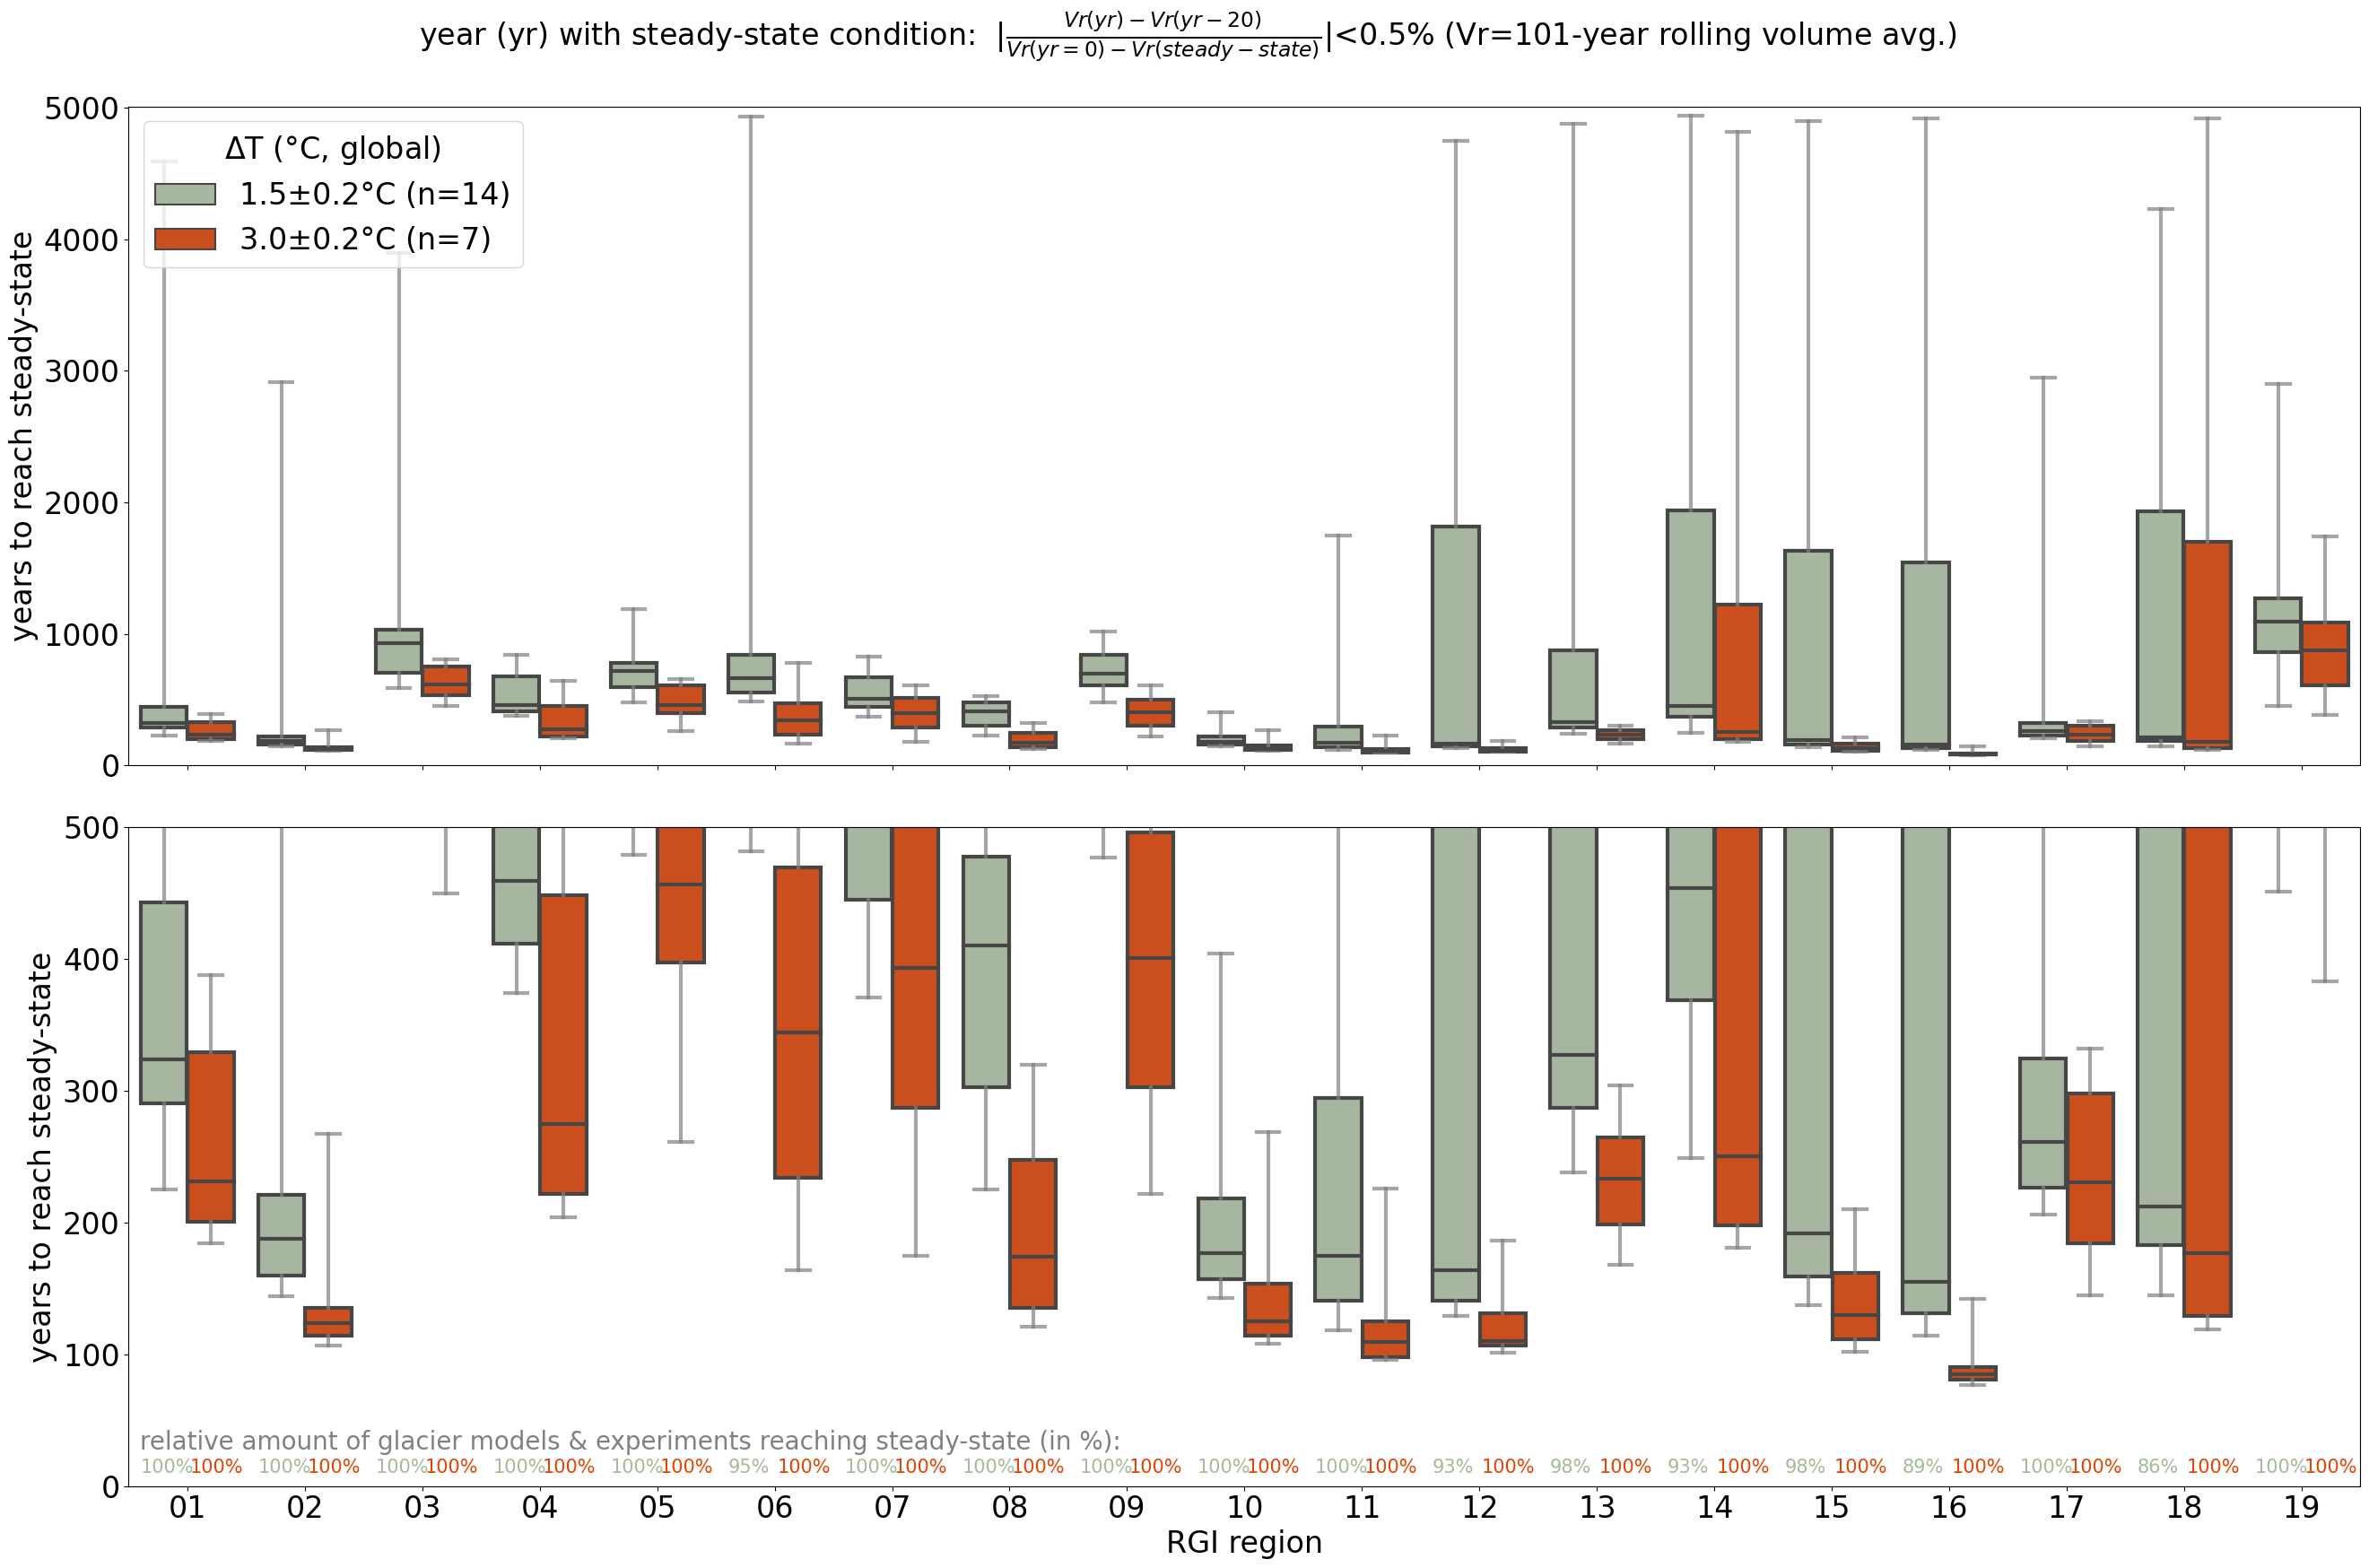

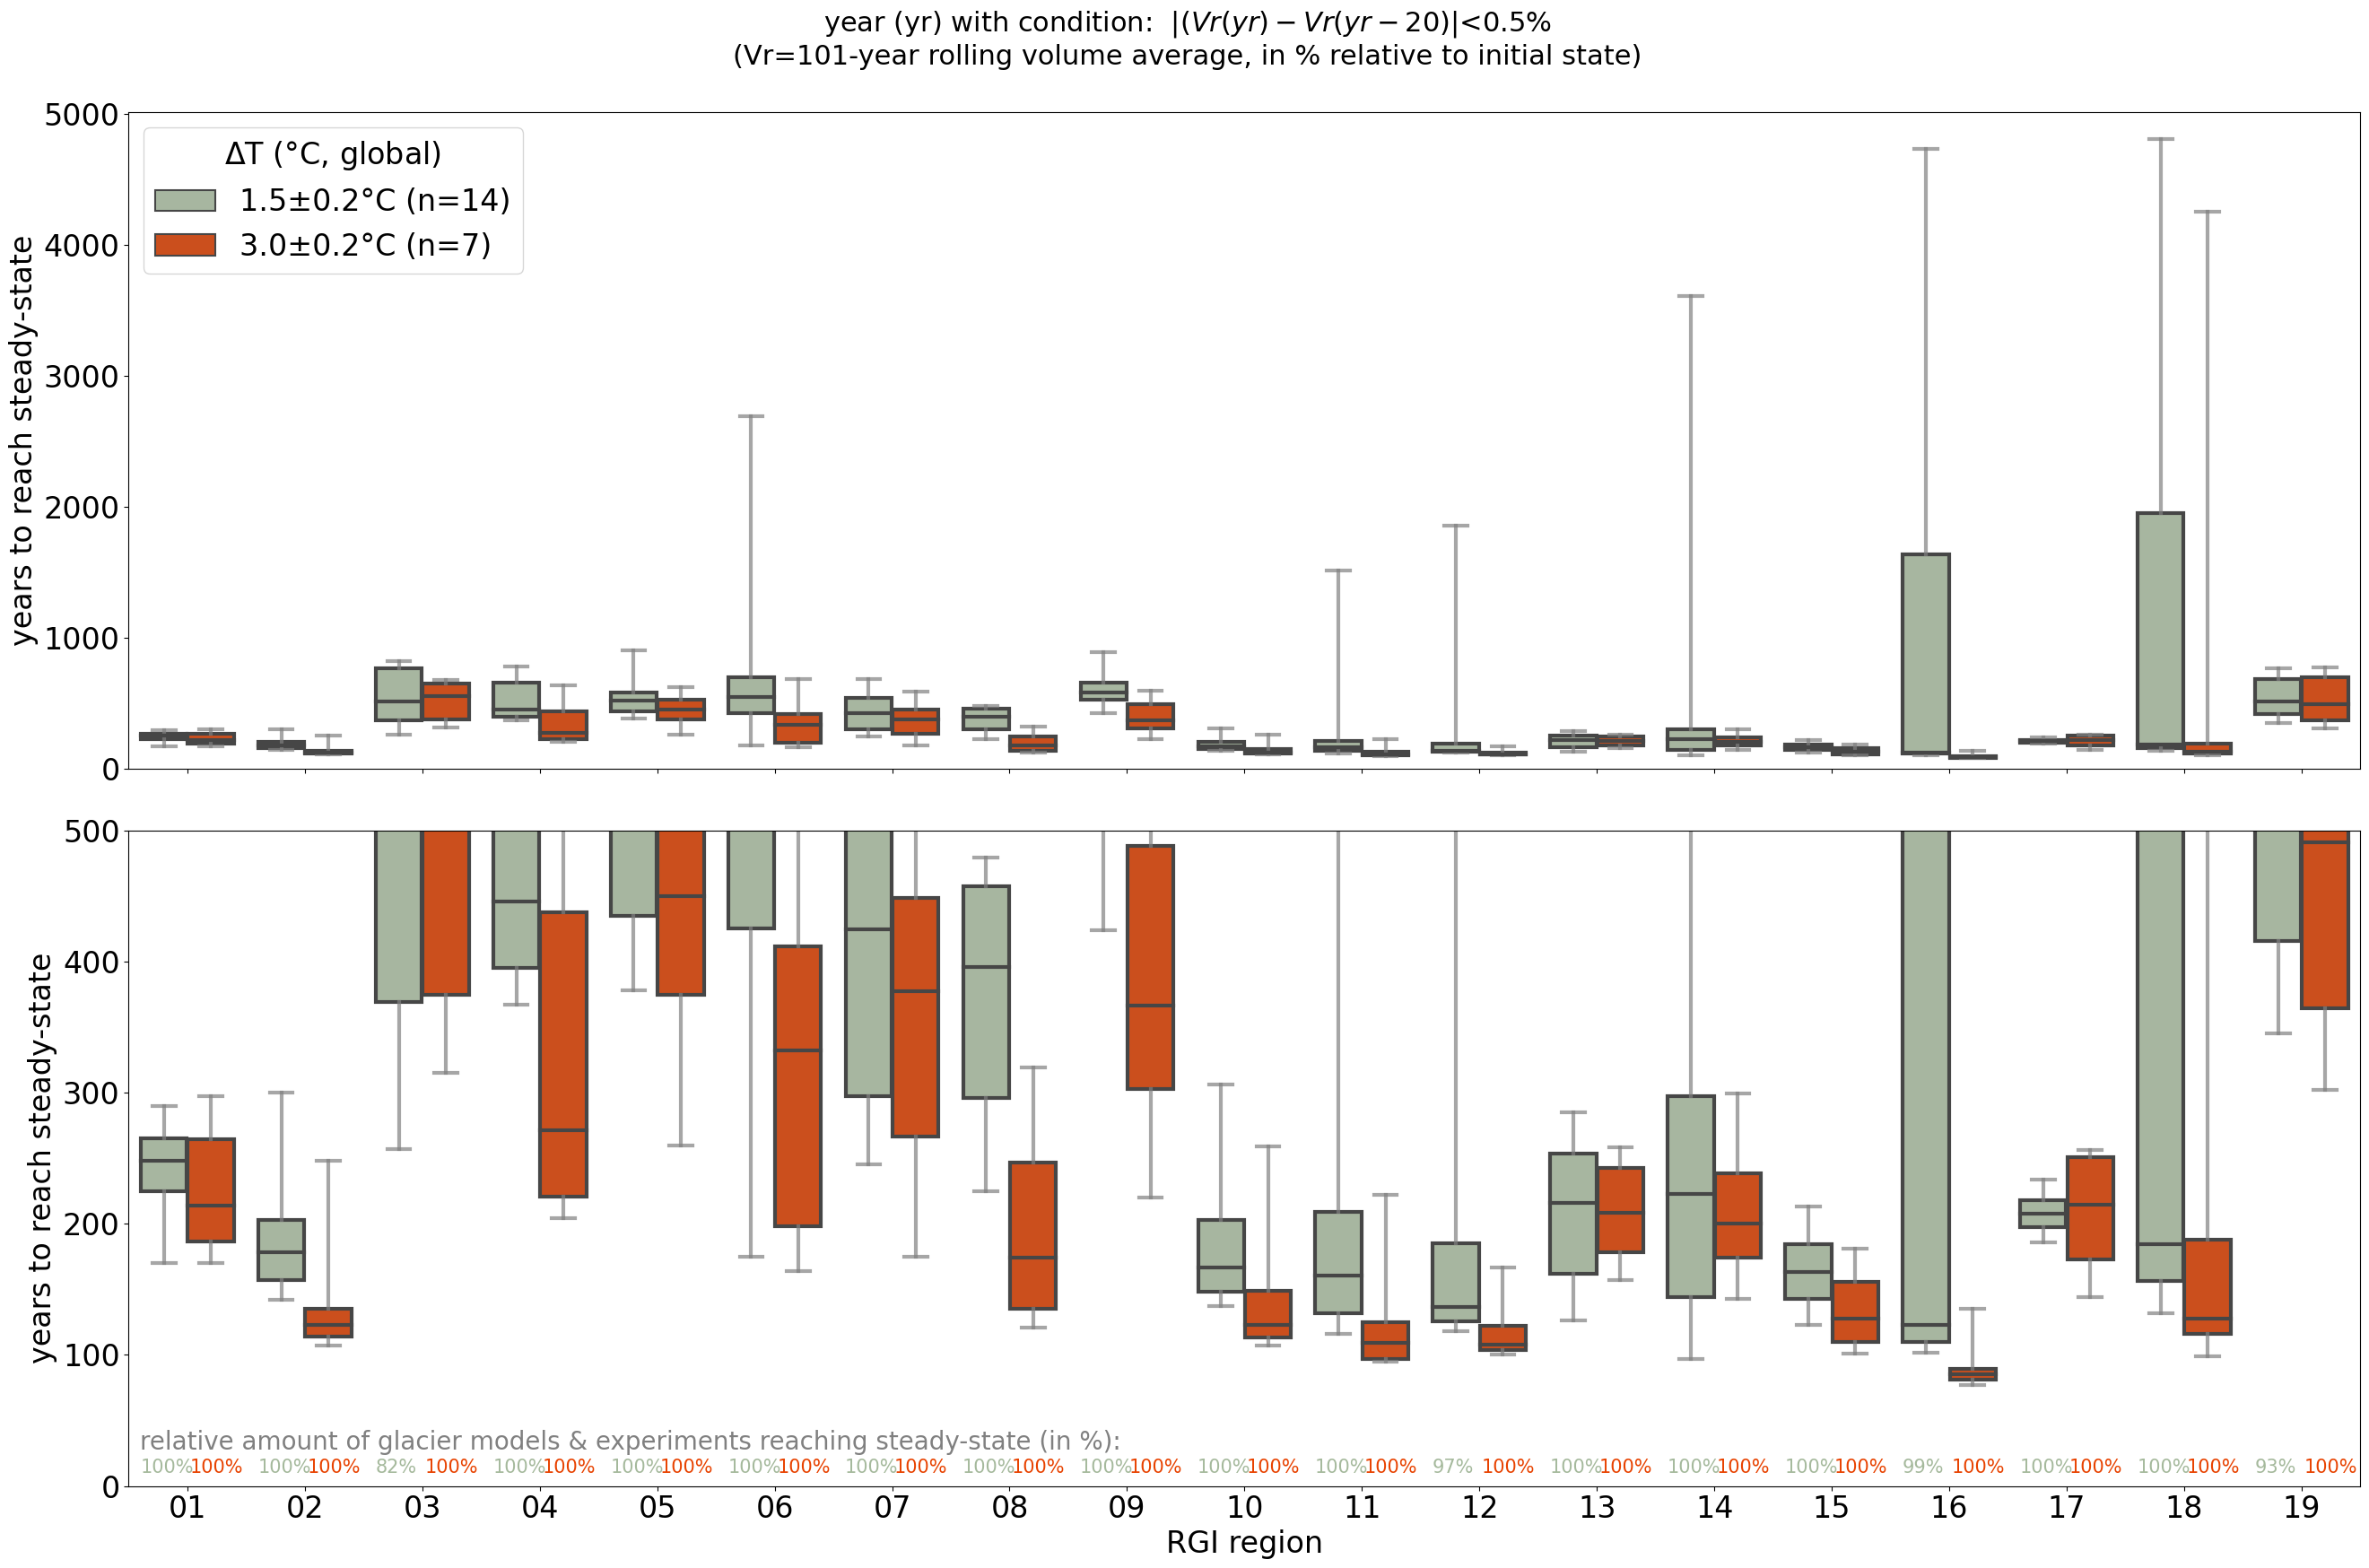

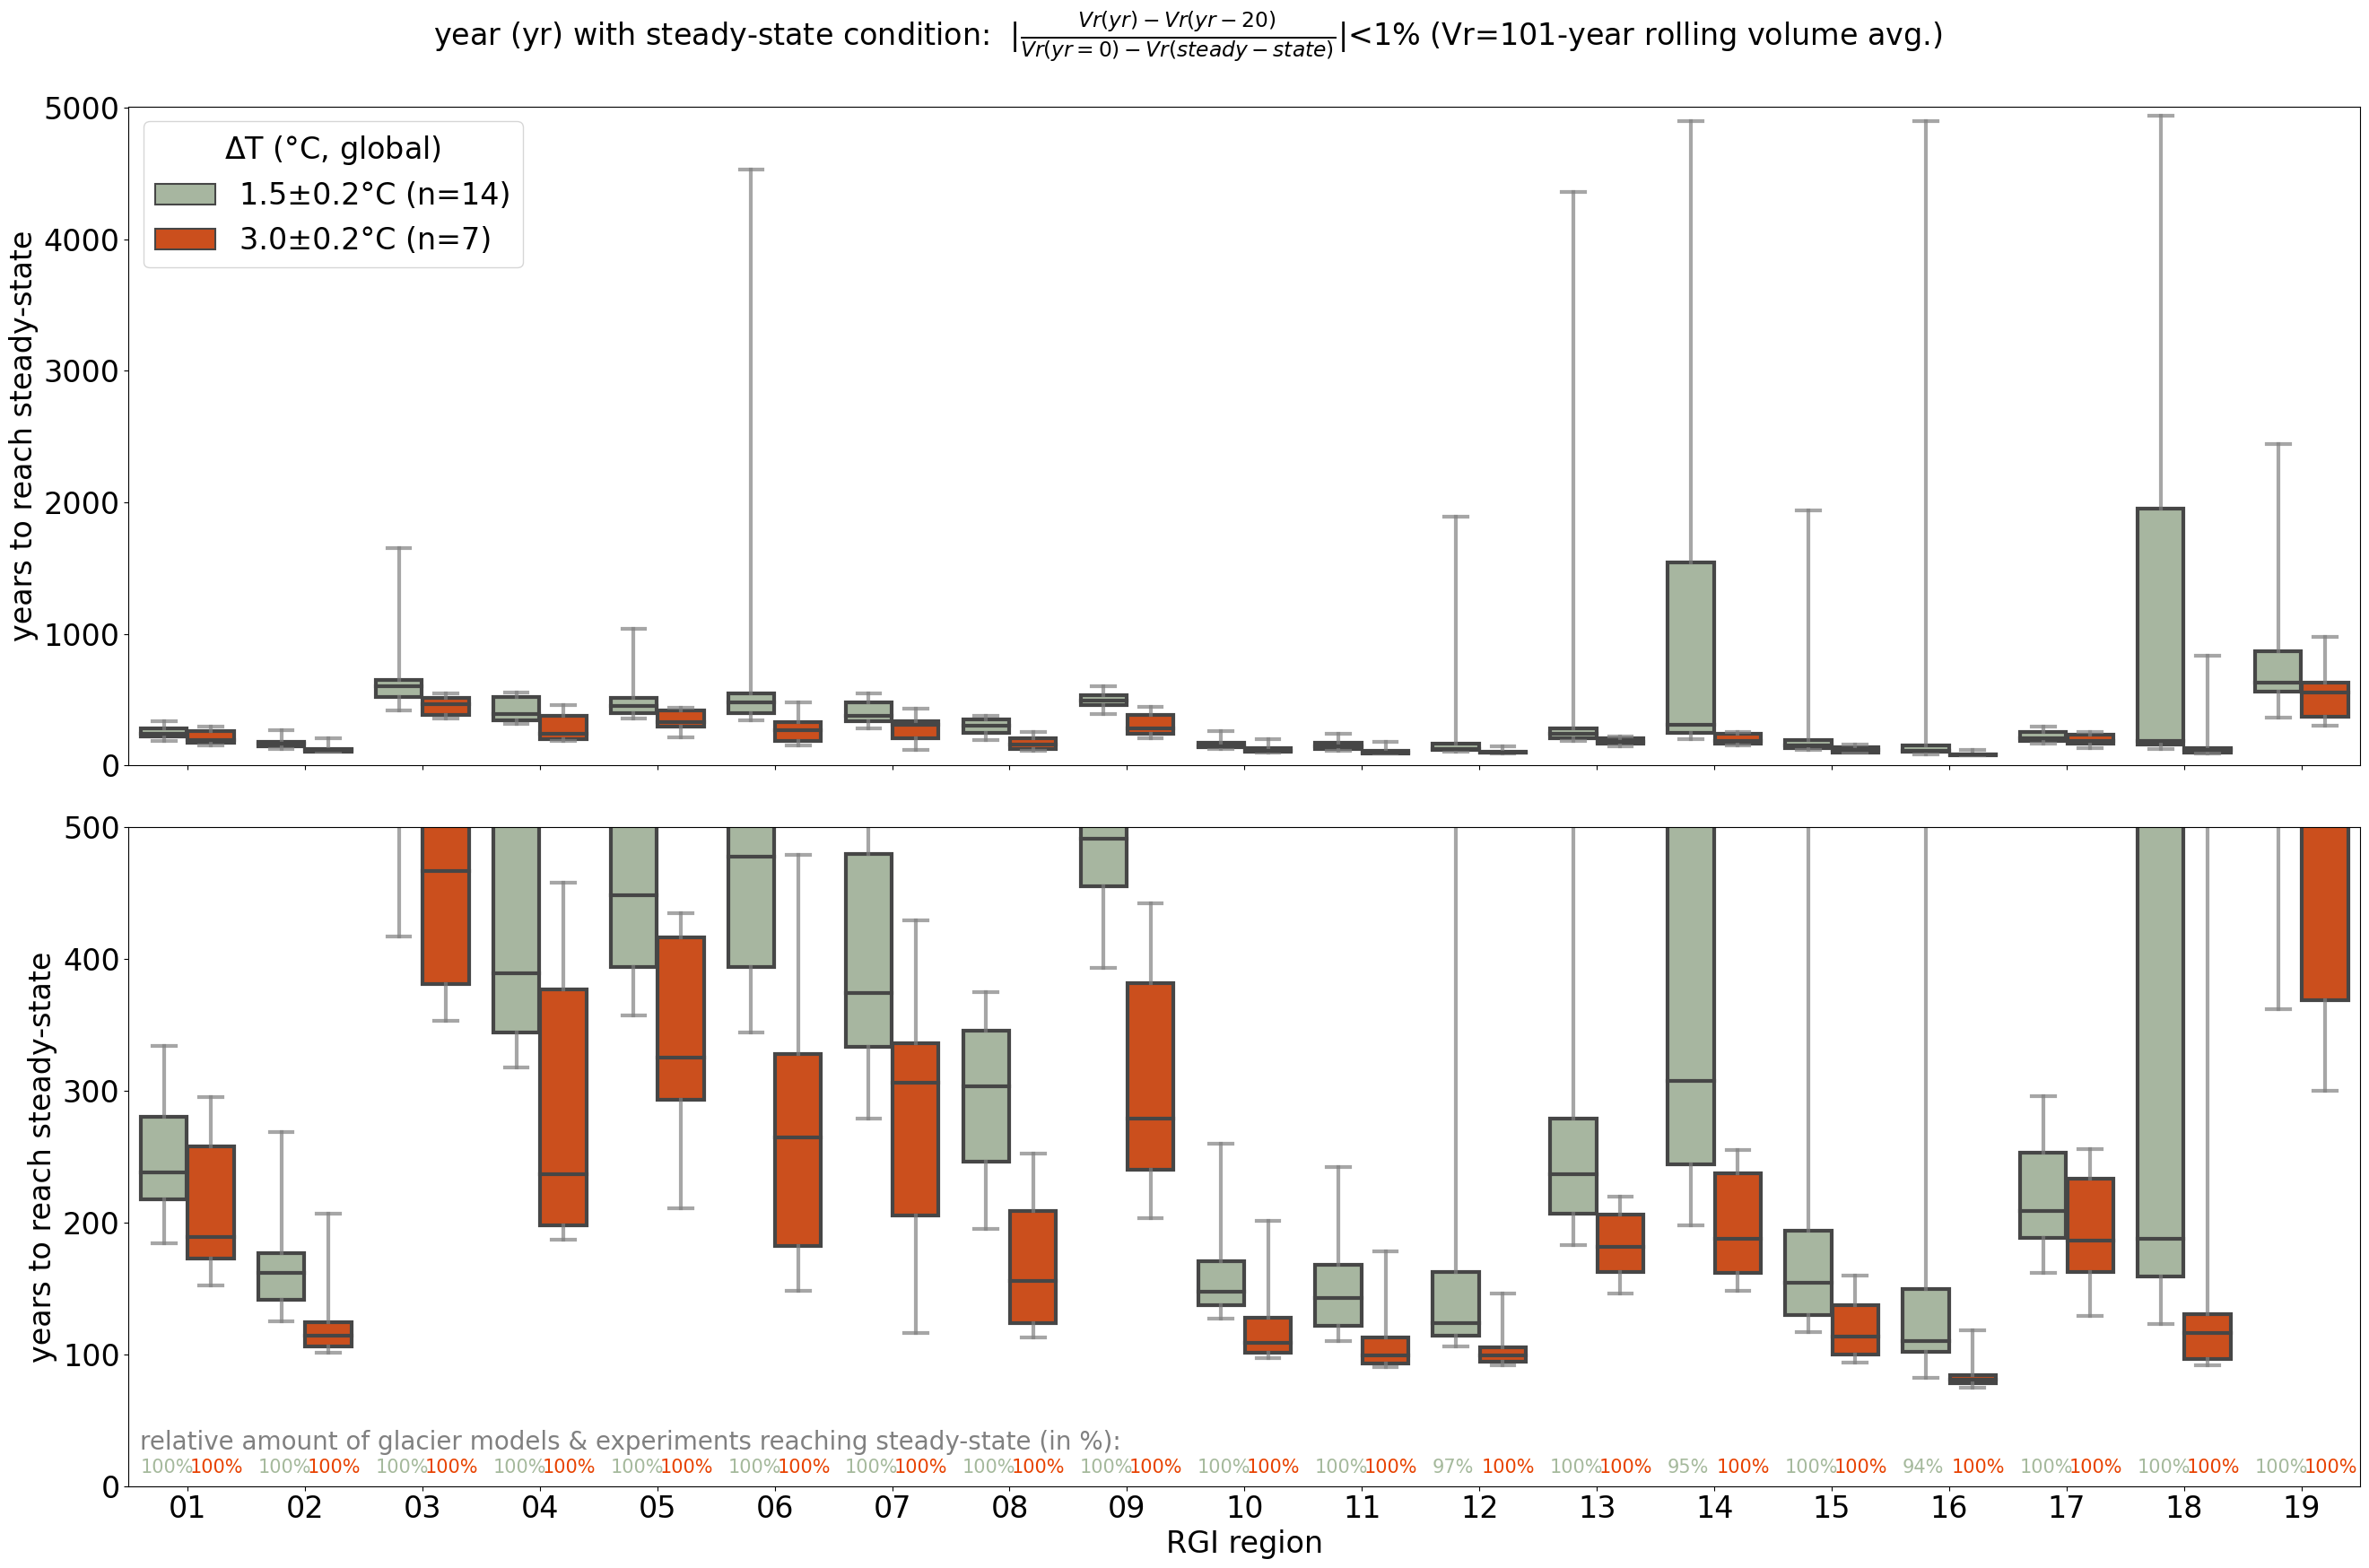

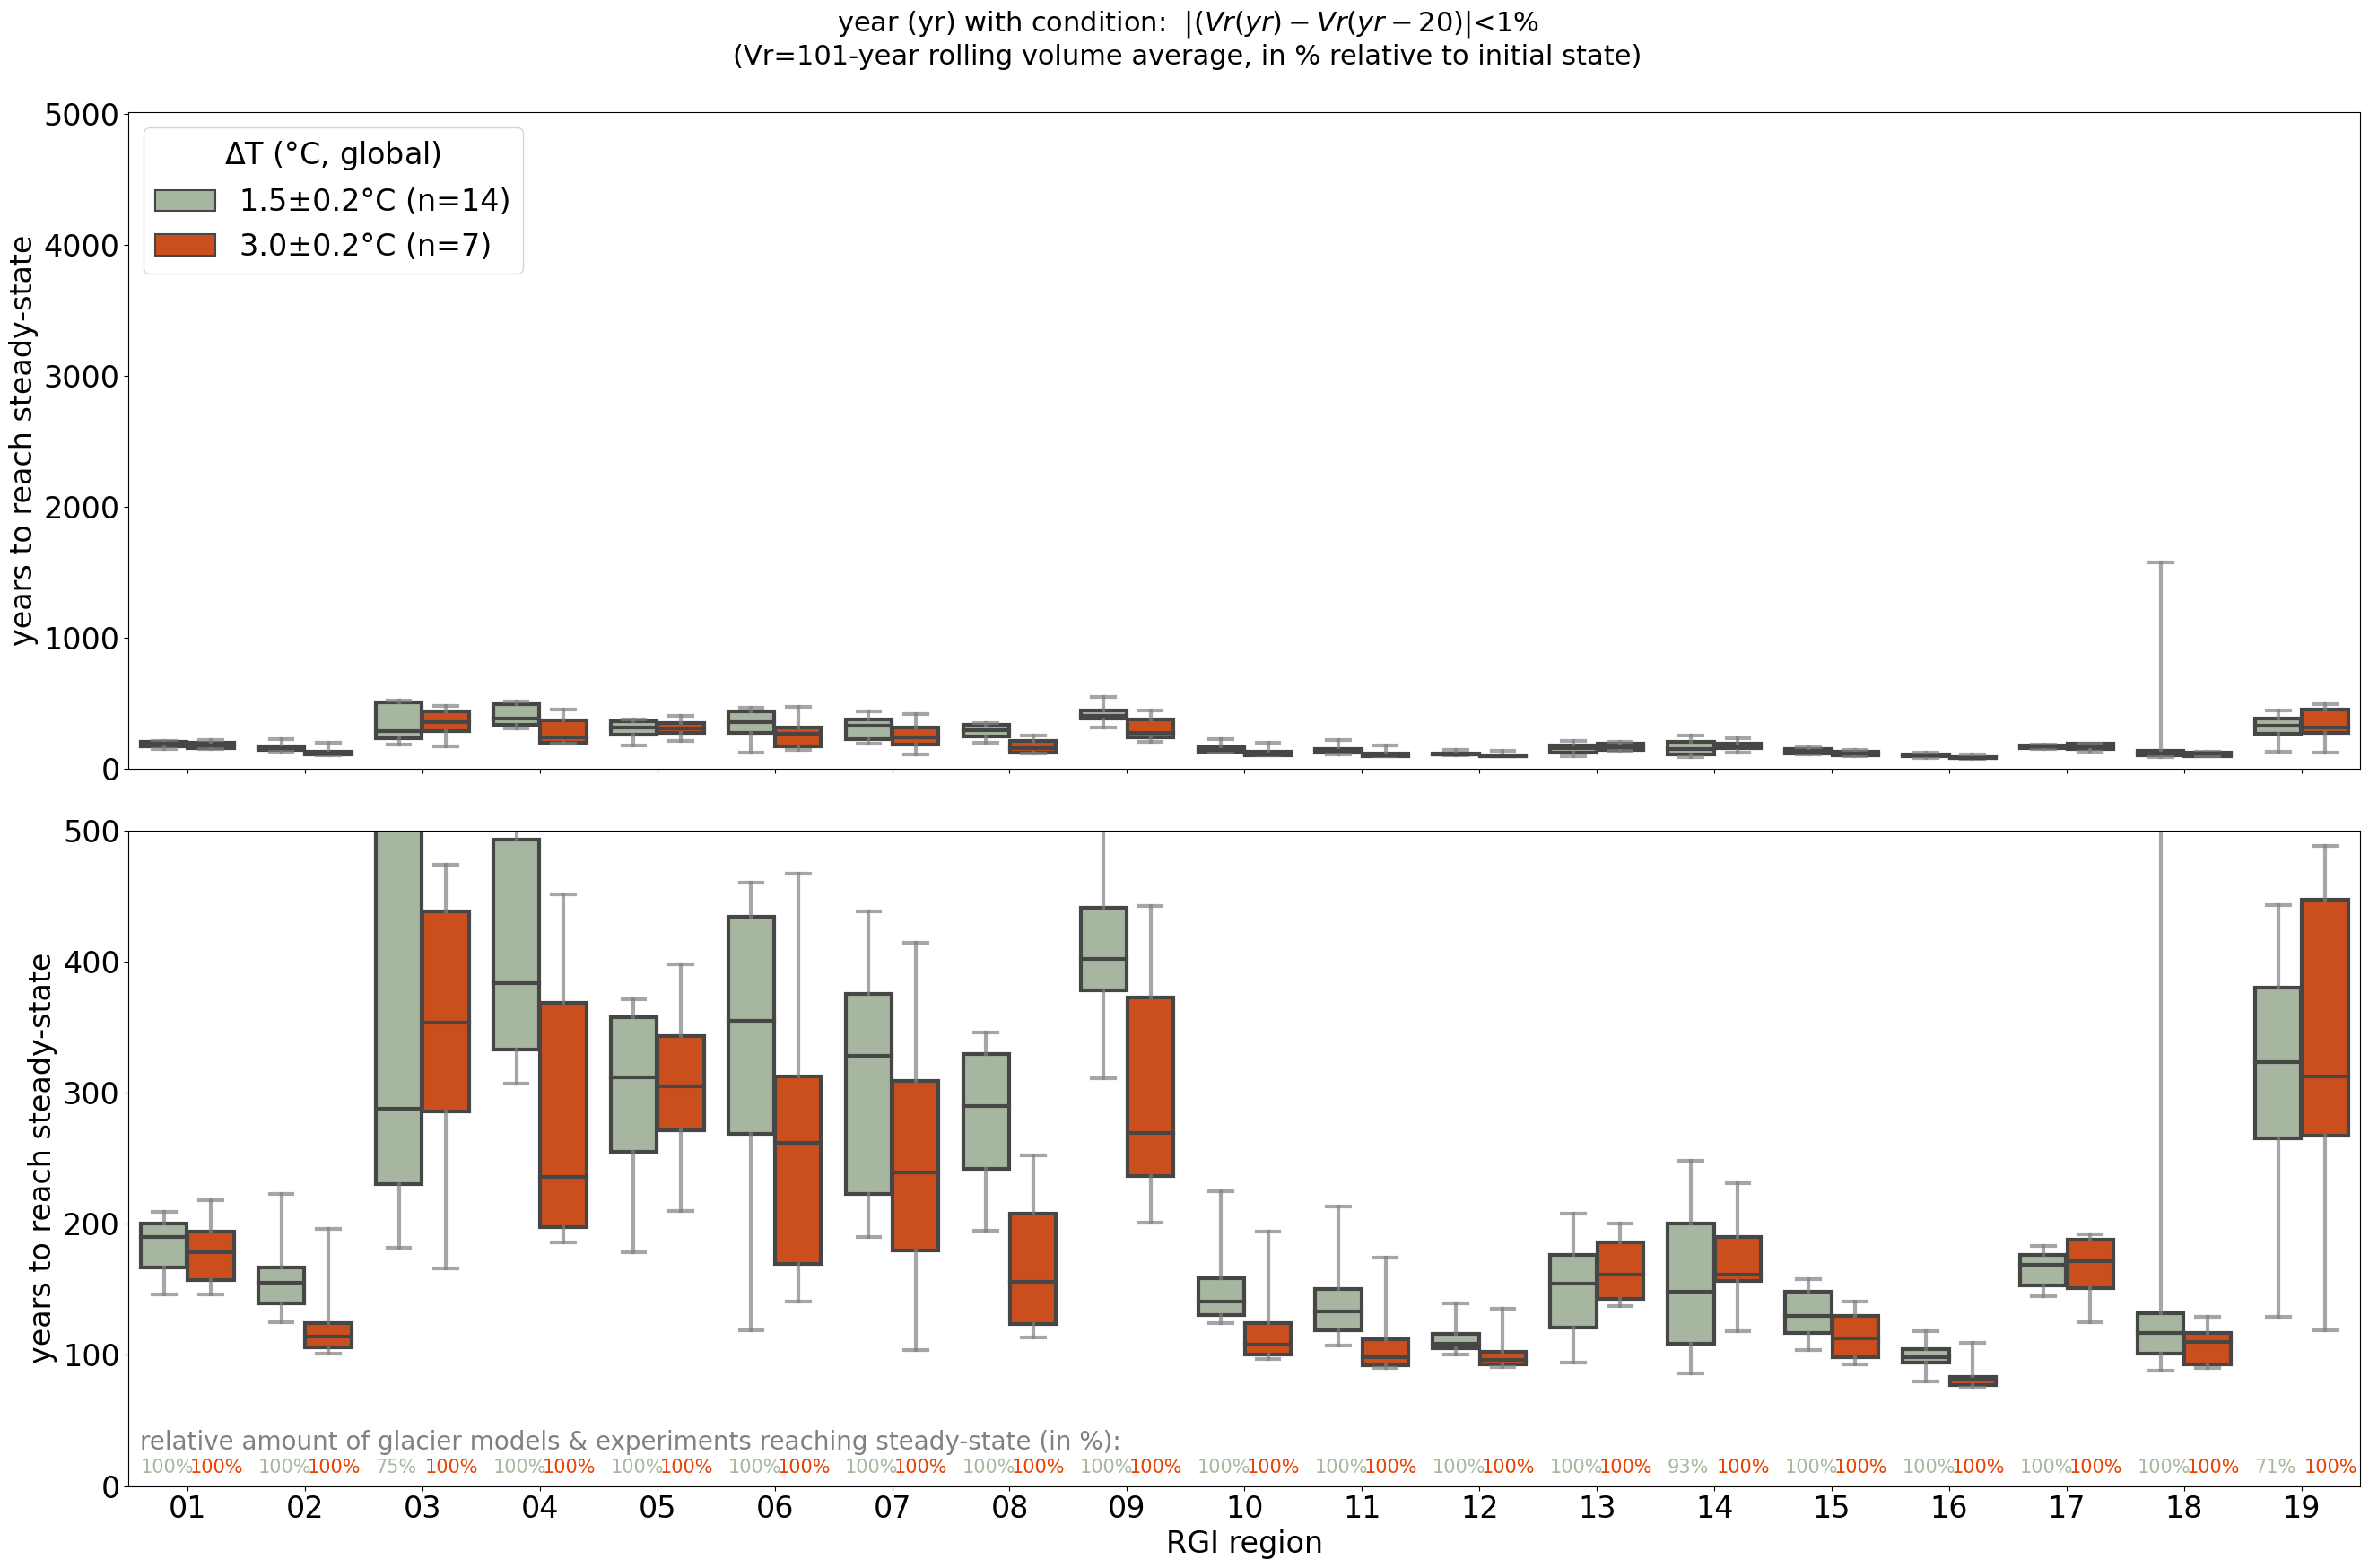

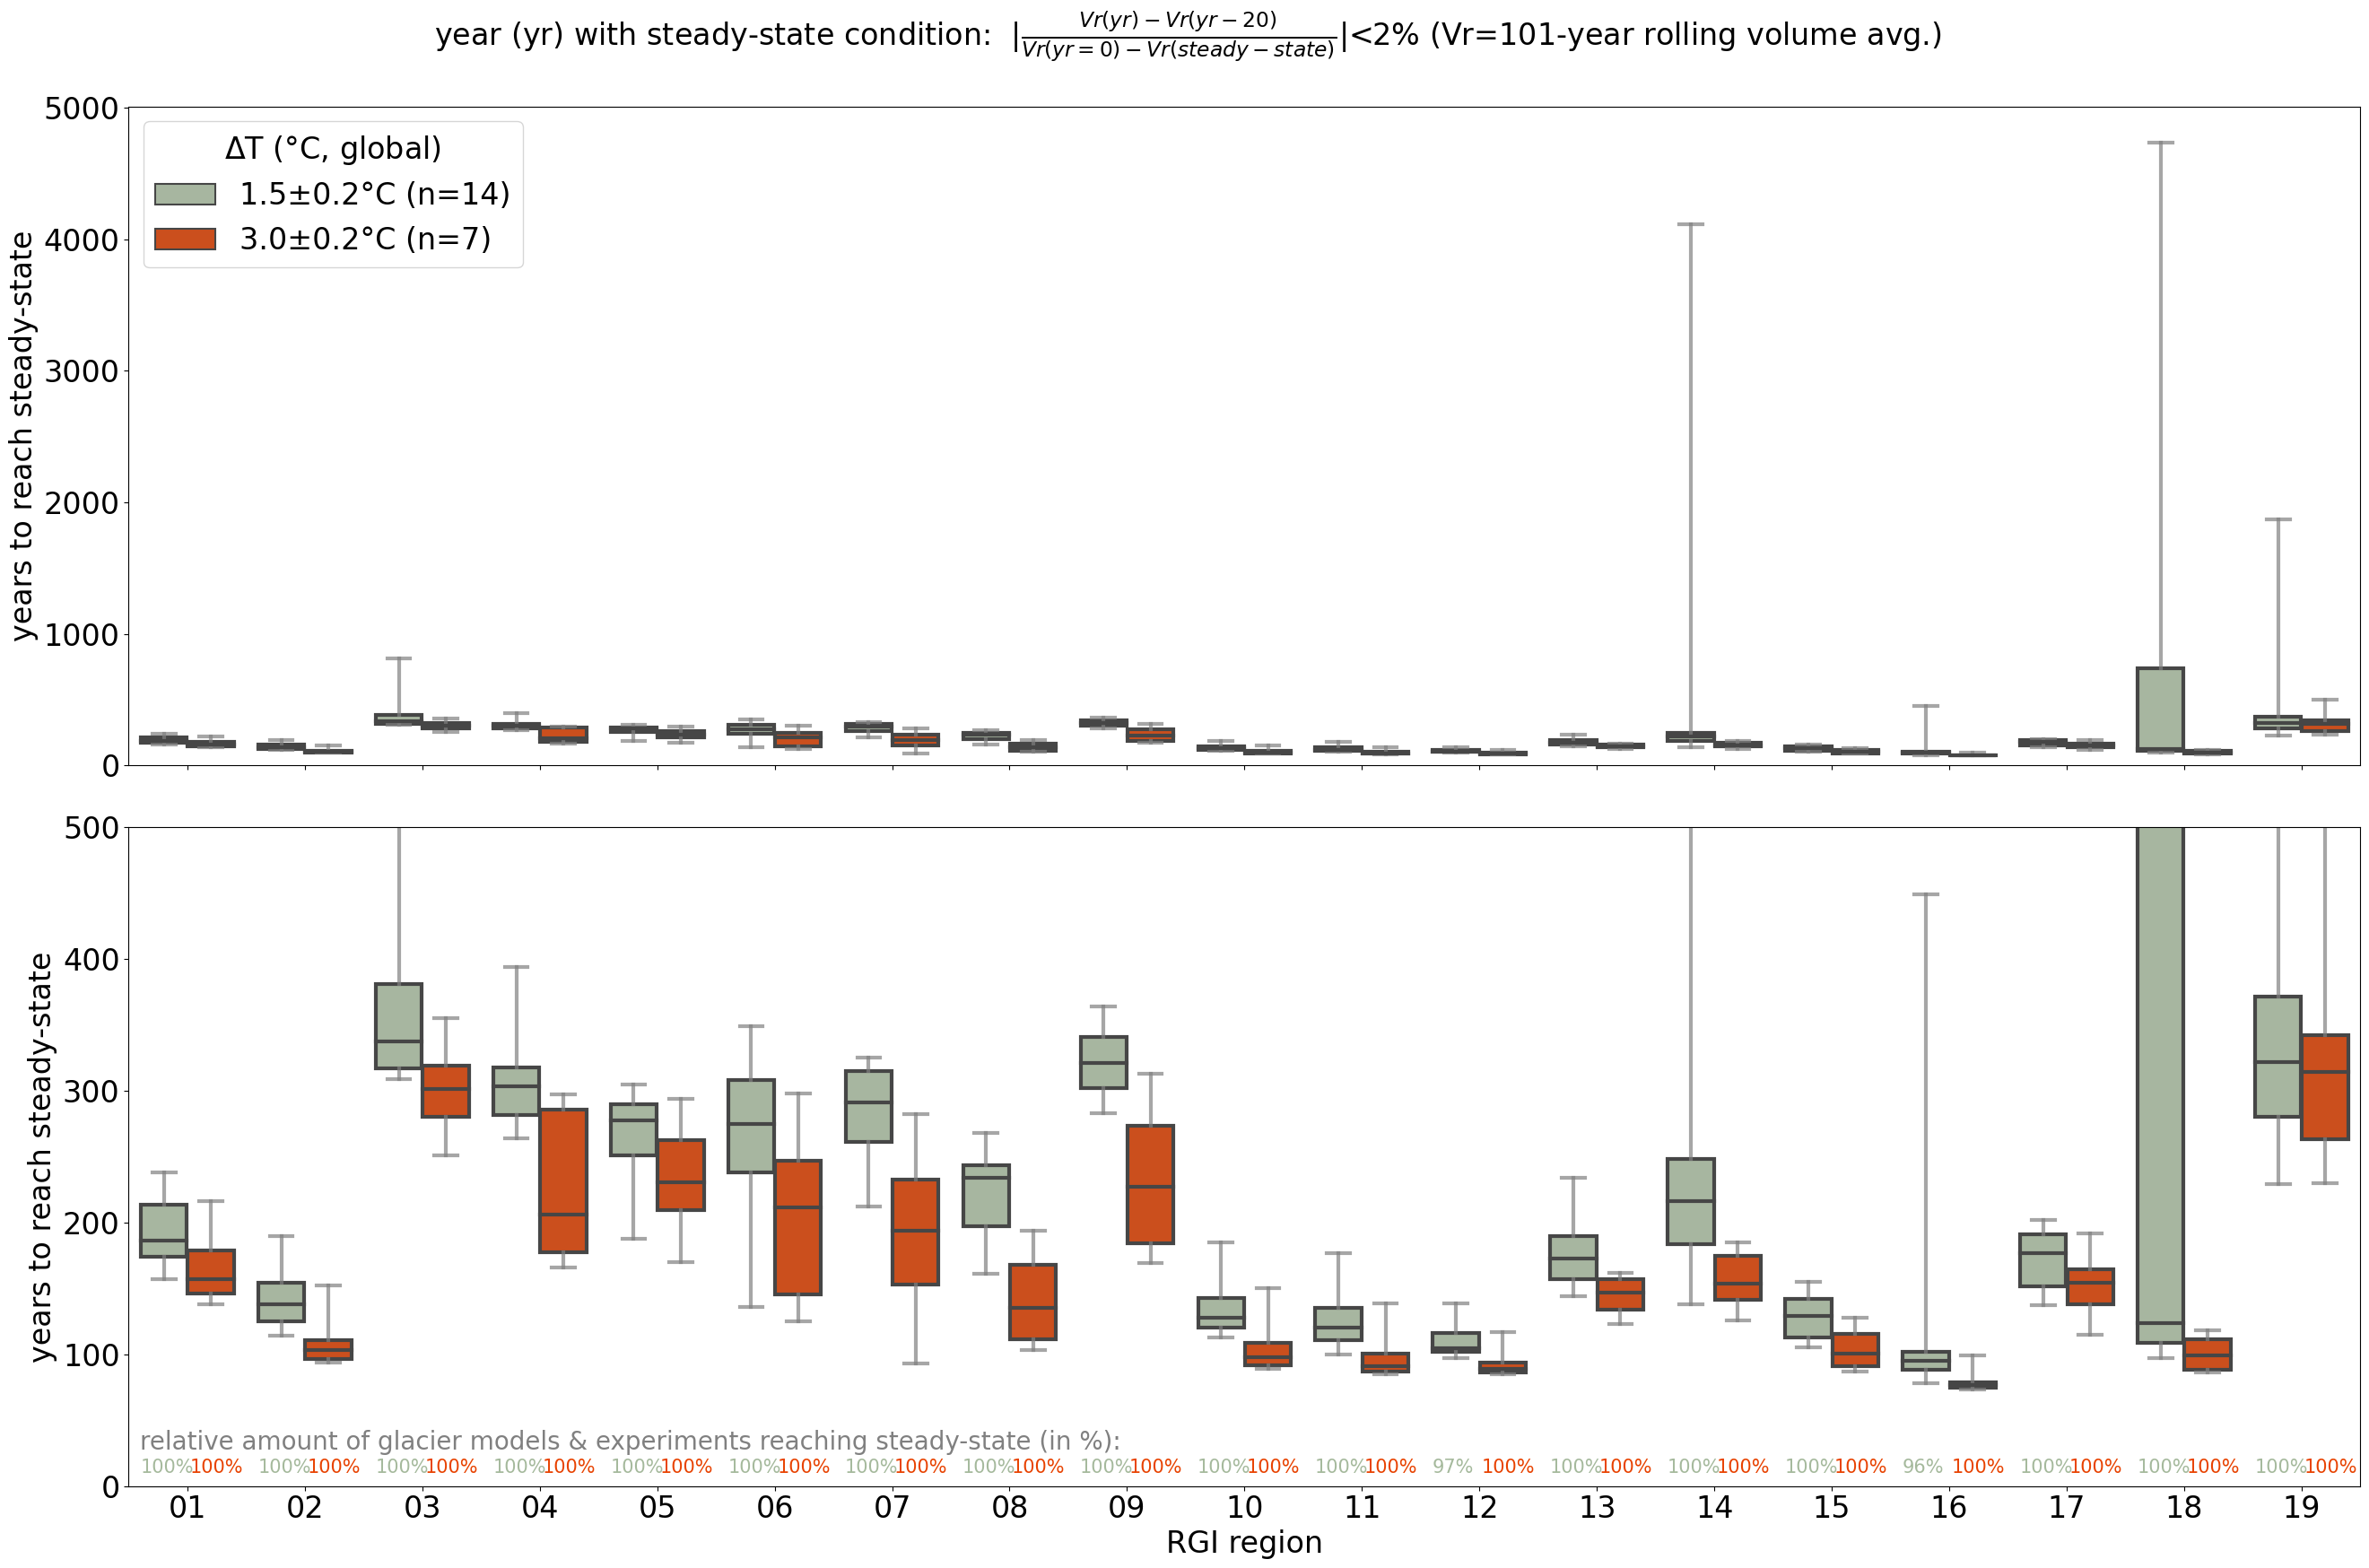

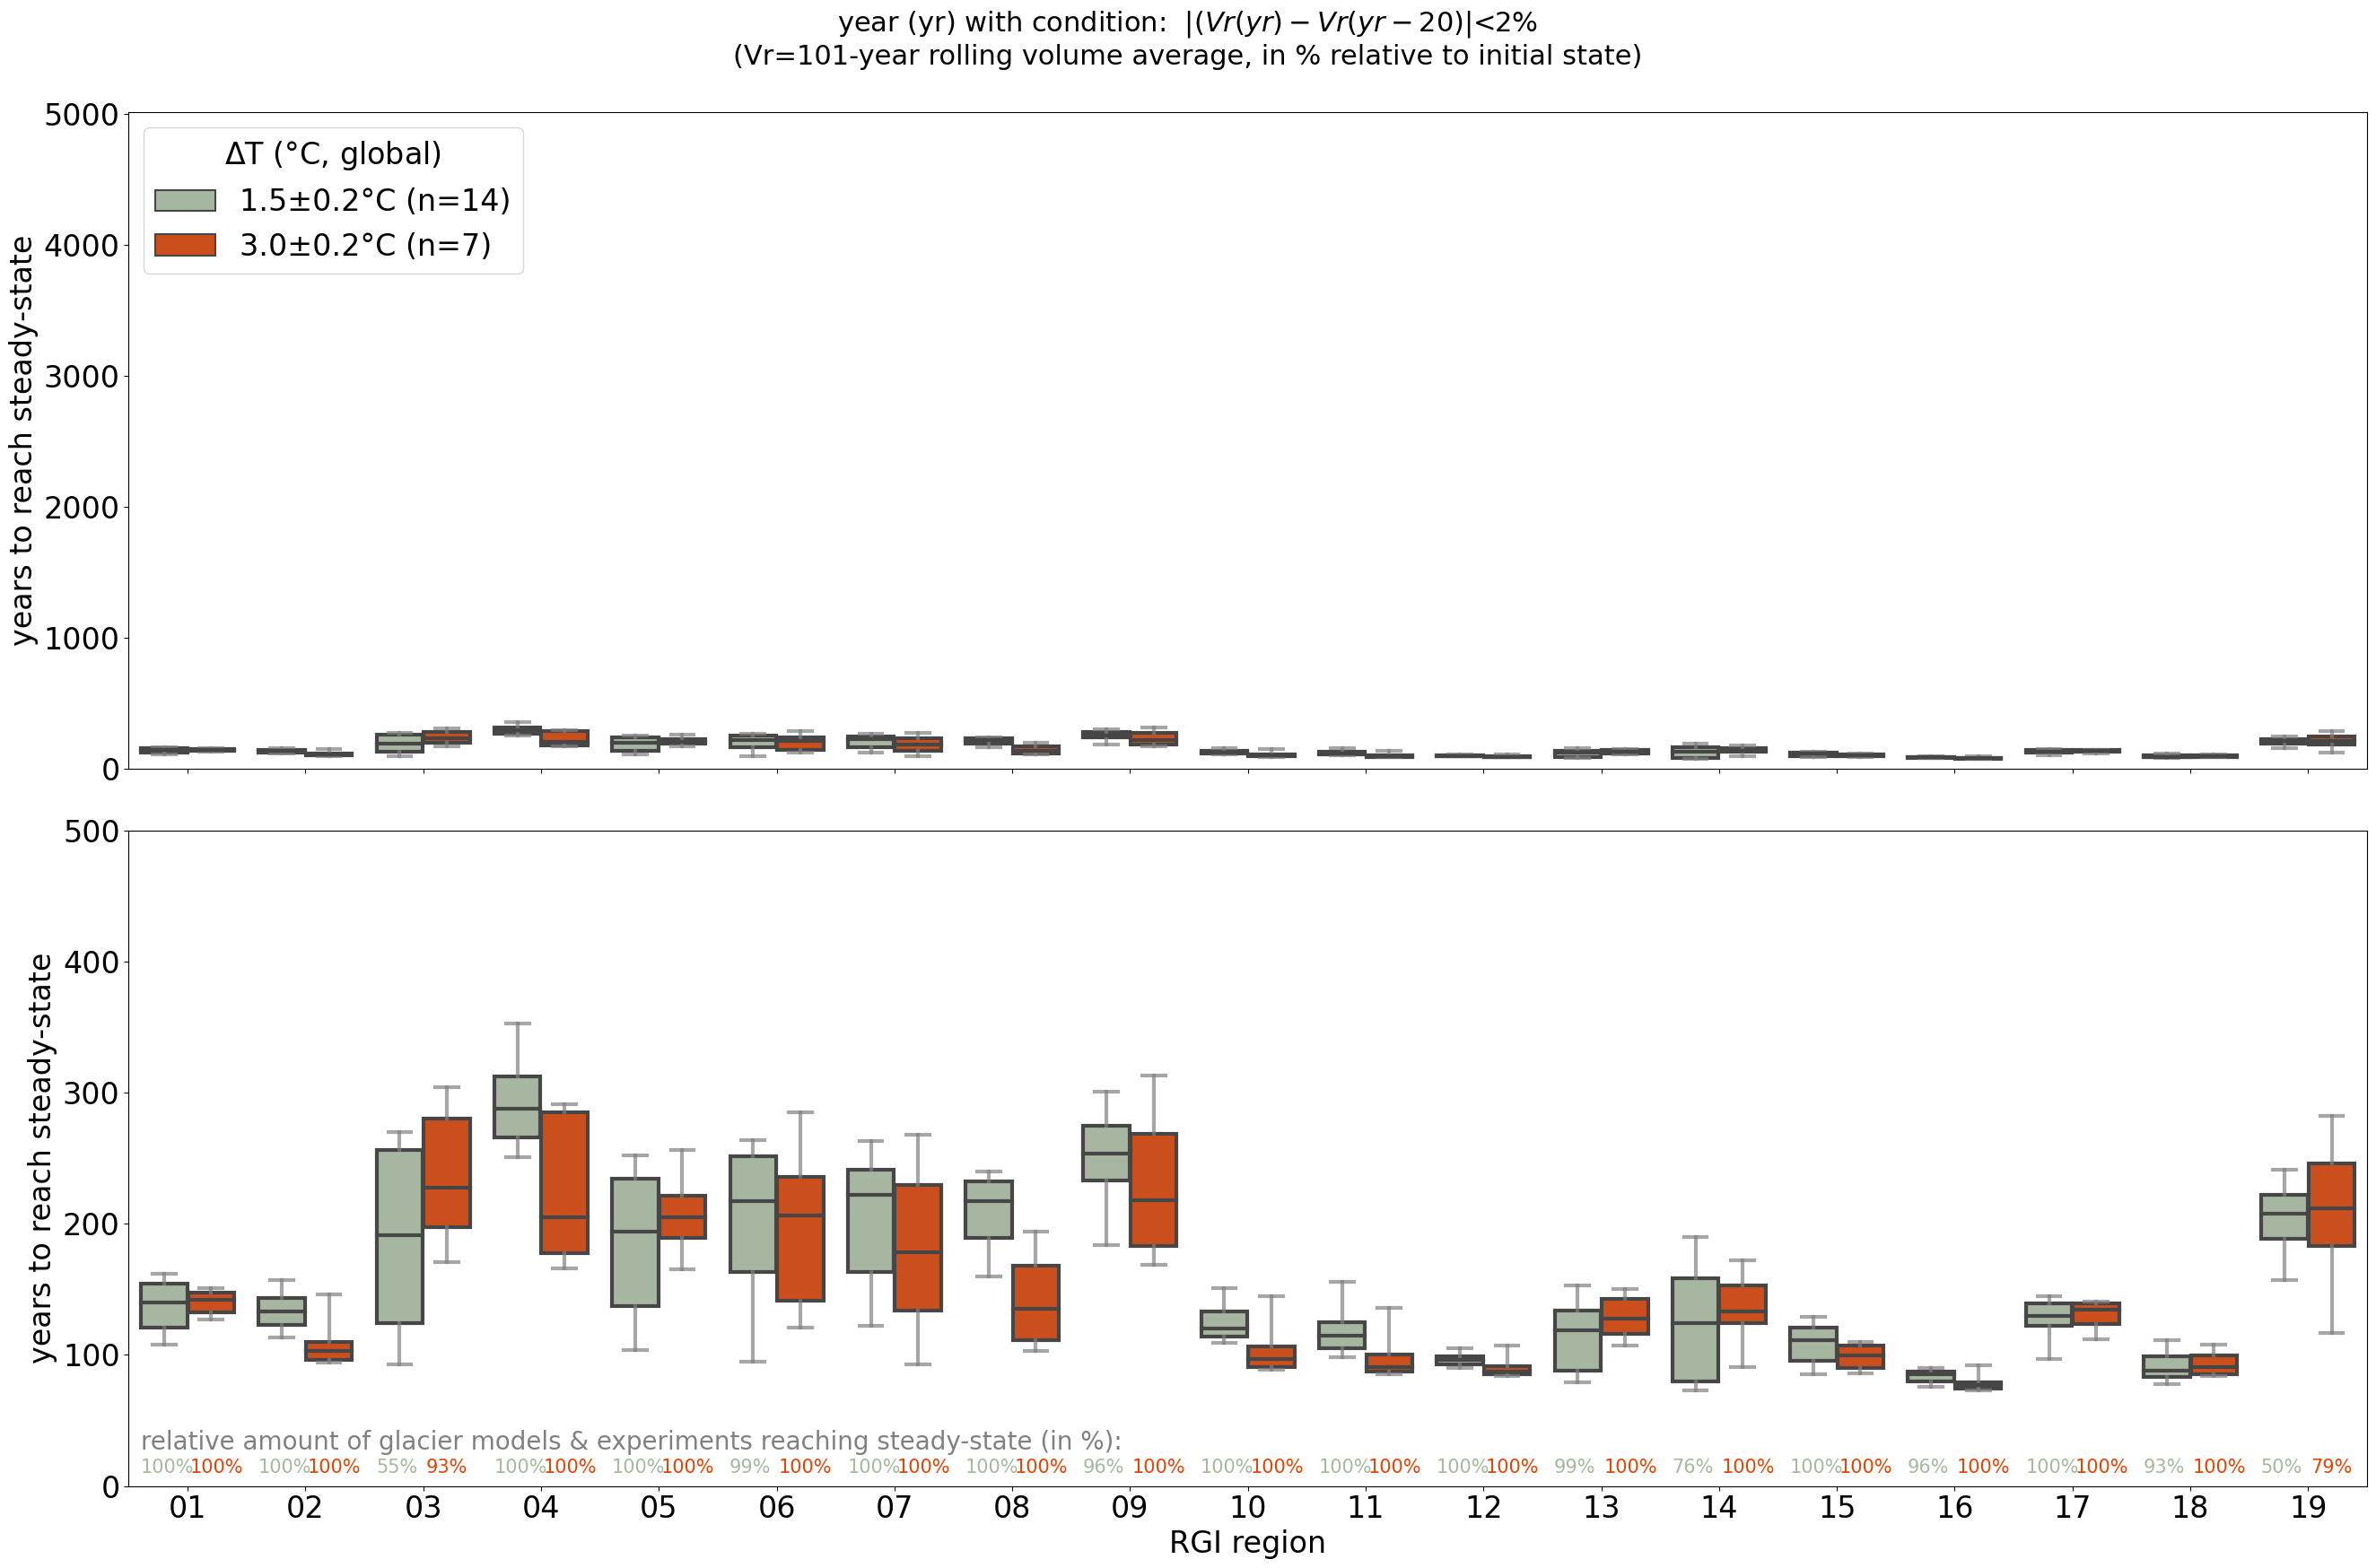

In [27]:
for xperc in [0.5,1,2]:
    for avg_yrs in [21, 101]: ###  61,
        for option in ['relative_to_total_change','relative_to_initial_state']:
            for threshold_total_change in [0]: #,25]:
                print(xperc, avg_yrs, option, threshold_total_change)
                year_reached_name = f'sim_yr_where_ss_lower_{xperc}perc_ch_reached_{option}_{avg_yrs}yr_vol_avg_{threshold_total_change}%_total_ch_threshold_min_period_{min_periods}'
                pd_equilibrium_yr_lower_xperc_ch_avg_yrs = pd_equilibrium_yr_lower_xperc_ch_avg_yrs_all[['gcm','period_scenario', 'rgi_reg','model',
                                                                                                         'temp_ch_ipcc',year_reached_name]].dropna()

                plt.rc('font', size=24)  

                rgi_regs = ['01', '02', '03', '04', '05', '06', '07',
                                   '08', '09', '10', '11', '12', '13', '14', '15',
                                   '16', '17', '18', '19'] #'All',

                condi15 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[(pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc>1.3) & (pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc<1.7)].index
                condi30 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[(pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc>2.8) & (pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc<3.2)].index
                n15 = len(condi15.unique())
                n30 = len(condi30.unique())
                pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[condi15,'temp_ch_class'] = f'1.5±0.2°C (n={n15})'
                pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[condi30,'temp_ch_class'] = f'3.0±0.2°C (n={n30})'


                fig, axs=plt.subplots(2,1,figsize=(27,18), sharex=True)
                for jj,ax in enumerate(axs):
                    #pd_equilibrium_yr_lower_xperc_ch_avg_yrs_f = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs.temp_ch_ipcc>=0.8]
                    # only those where equilibrium is reached ...
                    sns.boxplot(data=pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[pd_equilibrium_yr_lower_xperc_ch_avg_yrs[year_reached_name]<=5000],
                                x='rgi_reg',y=year_reached_name,
                               dodge = True, fliersize=0, whis = [5,95],  hue='temp_ch_class', hue_order = [f'1.5±0.2°C (n={n15})',f'3.0±0.2°C (n={n30})'],
                                                        linewidth=3,
                                            palette = colors_15_30,
                                                        capprops={'color':'grey', 'alpha':0.7},
                                                        whiskerprops={'color':'grey', 'alpha':0.7}, ax=ax)
                    ax.set_ylabel('years to reach steady-state')

                    if jj==0:
                        ax.set_ylim([0,5010])
                        ax.legend(loc='upper left', title=r'$\Delta$T (°C, global)')
                        ax.set_xlabel('')
                    else:
                        ax.set_ylim([0,500])
                        ax.set_xlabel('RGI region')
                        ax.legend().remove()

                        for j,rgi_reg in enumerate(rgi_regs):
                            condi3 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.rgi_reg==rgi_reg
                            _selcondi3 = pd_equilibrium_yr_lower_xperc_ch_avg_yrs.loc[condi3]

                            condi1_15 = _selcondi3.temp_ch_class==f'1.5±0.2°C (n={n15})'
                            condi1_30 = _selcondi3.temp_ch_class==f'3.0±0.2°C (n={n30})'

                            condi2 = _selcondi3[year_reached_name]<5000

                            _sel = _selcondi3.loc[(condi1_30)&(condi2)]
                            perc_30 = 100*len(_sel)/(len(_selcondi3.model.unique()) * n30)
                            #print(rgi_reg, perc_30)
                            perc_30 = np.round(perc_30)

                            _sel = _selcondi3.loc[(condi1_15)&(condi2)]
                            perc_15 = 100*len(_sel)/(len(_selcondi3.model.unique()) * n15)
                            #print(rgi_reg,perc_15)
                            perc_15 = np.round(perc_15)
                            plt.text(-0.4+j,10,f'{perc_15:.0f}%', color=colors_15_30[0], fontsize=15)
                            plt.text(0.02+j,10,f'{perc_30:.0f}%', color=colors_15_30[1], fontsize=15)
                plt.text(-0.4,28, f'relative amount of glacier models & experiments reaching steady-state (in %):', color='grey', fontsize=20)
                if option == 'relative_to_total_change':
                    if avg_yrs==21:
                        plt.suptitle('year (yr) with steady-state condition: '+r' $|\frac{Vr(yr)-Vr(yr-20)}{Vr(yr=0)-Vr(steady-state)}|$<'+f'{xperc}%'+ f'\n(Vr={avg_yrs}-year rolling volume average, threshold total change: {threshold_total_change})',
                                    fontsize=24)
                    elif avg_yrs==61:
                        plt.suptitle('year (yr) with steady-state condition: '+r' $|\frac{Vr(yr)-Vr(yr-20)}{Vr(yr=0)-Vr(steady-state)}|$<'+f'{xperc}%'+ f'\n(Vr={avg_yrs}-year rolling volume average, threshold total change: {threshold_total_change})',
                                    fontsize=24)

                    elif avg_yrs==101:
                        plt.suptitle('year (yr) with steady-state condition: '+r' $|\frac{Vr(yr)-Vr(yr-20)}{Vr(yr=0)-Vr(steady-state)}|$<'+f'{xperc}%'+ f' (Vr={avg_yrs}-year rolling volume avg.)', #, threshold total change: {threshold_total_change})',
                                    fontsize=24)
                    savefig_name = f'figures/2_{100-xperc:.0f}%_of_steady_state_per_rgi_region_boxplots_{avg_yrs}_avg_1_5_3_0_div_total_change_{threshold_total_change}%_total_ch_threshold.png'
                else:
                    if avg_yrs==21:
                        plt.suptitle('year (yr) with steady-state condition: '+r' $|Vr(yr)-Vr(yr-20)|$<'+f'{xperc}%'+ f'\n(Vr={avg_yrs}-year rolling volume average, in % relative to initial state)', fontsize=22)
                    elif avg_yrs==61:
                        plt.suptitle('year (yr) with steady-state condition: '+r' $|Vr(yr)-Vr(yr-20)|$<'+f'{xperc}%'+ f'\n(Vr={avg_yrs}-year rolling volume average, in % relative to initial state)', fontsize=22)

                    elif avg_yrs==101:
                        plt.suptitle('year (yr) with condition: '+r' $|(Vr(yr)-Vr(yr-20)|$<'+f'{xperc}%'+ f'\n(Vr={avg_yrs}-year rolling volume average, in % relative to initial state)',
                                     fontsize=22)
                        
                savefig_name = f'figures/2_{100-xperc:.1f}%_steady_state_{option}_per_rgi_region_boxplots_{avg_yrs}_avg_1_5_3_0_{threshold_total_change}%_total_ch_threshold_min_period_{min_periods}.png'
                plt.tight_layout()

                plt.savefig(savefig_name)
                if avg_yrs!=101:
                    plt.close()